Fouille de données


Détection d'anomalies

## Introduction et objectifs

### Modules

**NB :** Veuillez n'utiliser que les modules spécifiés ci-dessous.

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report, pairwise_distances
from scipy import stats
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
# Assurer la reproductibilité des résultats
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

### Objectifs du TP

La détection d’anomalies est une tâche importante en apprentissage automatique. Elle vise à identifier des observations atypiques qui se distinguent significativement du comportement général des données. Elle est largement utilisée dans divers domaines, tels que la détection de fraudes bancaires, la surveillance des réseaux, ou encore le contrôle qualité. Dans ce TP, l’objectif  principal est de détecter les transactions frauduleuses dans le jeu de données fourni. Pour cela, vous explorerez plusieurs approches complémentaires :
* Méthodes statistiques pour identifier les valeurs extrêmes,
* Techniques de clustering pour regrouper les comportements similaires,
* Méthodes basées sur la reconstruction (auto-encodeurs) qui apprennent à modéliser les données normales,
* Technique du LOF.

Le jeu de données contient les étiquettes réelles des transactions que vous pouvez utiliser pour évaluer la performance de vos méthodes et analyser leurs forces et faiblesses.

### Données du TP

Dans ce TP, vous allez effectuer la détection d'anomalie sur un ensemble de transactions effectuées sur un site e-commerce. Chaque entrée du jeu de données correspond à une transaction unique liée à un seul produit et réalisée par un client. Chaque transaction est caractérisée par la date/heure, la catégorie du produit, le prix unitaire, la quantité, le moyen de paiement, la ville, l'ancienneté du compte en jours, et le montant total correspondant au produit de la quantité et du prix unitaire. Finalement, chaque transaction dispose d'une variable « fraude » qui prend la valeur 1 (fraude) ou 0 (non fraude) pour indiquer s'il s'agit d'une transaction frauduleuse ou non.

#### Google Collab

In [4]:
#from google.colab import drive

In [5]:
#drive.mount('/content/drive')
#ROOT = "/content/drive/My Drive/Trimestres/Automne 25/TP3 - INF8111/" # Remplacer par le chemin du fichier

#### Exécution Locale

In [6]:
# Remplacer par le chemin du fichier
ROOT = './'

#### Lecture des Données

In [7]:
df = pd.read_csv(ROOT+'DATA/transactions_ecommerce.csv')

In [8]:
df.head()

,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
0,10000,2023-06-08 12:00:00,C1028,P267,Décoration,1,197.21,PayPal,Toulouse,57,144,0,197.21
1,10001,2023-05-29 19:00:00,C1906,P178,Art de la table,5,41.54,Virement,Bordeaux,69,750,0,207.70
2,10002,2023-05-08 13:00:00,C1032,P253,Art de la table,4,31.74,Carte,Paris,20,784,0,126.96
3,10003,2023-06-08 18:00:00,C1645,P415,Décoration,2,11.65,Carte,Paris,29,632,0,23.30
4,10004,2023-05-19 15:00:00,C1878,P056,Décoration,3,39.56,PayPal,Bordeaux,56,340,0,118.68


## Partie 1 : Exploration et Analyse Préliminaire (10 points)


### Question 1.1 (1 point)

**Affichez le nombre total de transactions, ainsi que la liste des variables associées à chaque transaction et leurs types de données.**

In [9]:
# TO DO
print(f"\nNombre total de transactions : {len(df)}")
print(f"Nombre de variables : {df.shape[1]}")

print("Variables et types de données")
print("=" * 70)
print("\n{:<30} {:<20}".format("Variable", "Type"))
print("-" * 70)
for col in df.columns:
    print("{:<30} {:<20}".format(col, str(df[col].dtype)))



Nombre total de transactions : 1050
Nombre de variables : 13
Variables et types de données

Variable                       Type                
----------------------------------------------------------------------
transaction_id                 int64               
date_heure                     object              
client_id                      object              
produit_id                     object              
catégorie                      object              
quantité                       int64               
prix_unitaire                  float64             
moyen_paiement                 object              
ville                          object              
âge_client                     int64               
ancienneté_compte_jours        int64               
fraude                         int64               
montant_total                  float64             


### Question 1.2 (3 points)

**Déterminez le nombre puis le pourcentage d’anomalies (classe 1) présentes dans le jeu de données. Visualisez la répartition des classes de la variable fraude à l’aide d’un pie chart ou d’un countplot, puis commentez brièvement vos observations.**

ANALYSE DES FRAUDES

Nombre de transactions normales (classe 0) : 1000
Nombre de transactions frauduleuses (classe 1) : 50

Pourcentage de transactions normales : 95.24%
Pourcentage de transactions frauduleuses : 4.76%


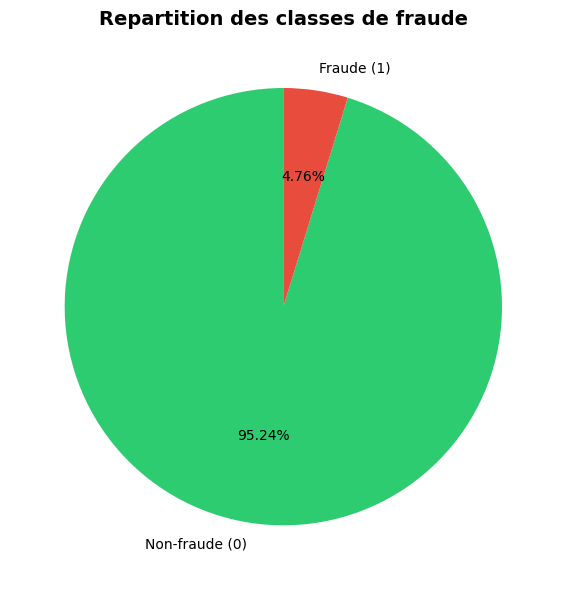


      Le jeu de donnée de présente 95.24% de transactions qui
      sont normales contre seulement 4.76% de fraudes. Ce taux de fraude
      de 4.76% est anormalement élevé comparé aux données réelles d'e-commerce
      (généralement < 1%). Ce dataset semble avoir été enrichi en cas
      de fraude pour faciliter l'apprentissage et l'évaluation des modèles 
      de détection
      


In [10]:
# TO DO
fraude_counts = df['fraude'].value_counts()
fraude_percentages = df['fraude'].value_counts(normalize=True) * 100

print("=" * 70)
print("ANALYSE DES FRAUDES")
print("=" * 70)
print(f"\nNombre de transactions normales (classe 0) : {fraude_counts[0]}")
print(f"Nombre de transactions frauduleuses (classe 1) : {fraude_counts[1]}")
print(f"\nPourcentage de transactions normales : {fraude_percentages[0]:.2f}%")
print(f"Pourcentage de transactions frauduleuses : {fraude_percentages[1]:.2f}%")

# Visualisation avec pie chart
plt.figure(figsize=(8, 6))
colors = ['#2ecc71', '#e74c3c']
plt.pie(fraude_counts, labels=['Non-fraude (0)', 'Fraude (1)'], 
        autopct='%1.2f%%', colors=colors, startangle=90)
plt.title('Repartition des classes de fraude', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


print("""
      Le jeu de donnée de présente 95.24% de transactions qui
      sont normales contre seulement 4.76% de fraudes. Ce taux de fraude
      de 4.76% est anormalement élevé comparé aux données réelles d'e-commerce
      (généralement < 1%). Ce dataset semble avoir été enrichi en cas
      de fraude pour faciliter l'apprentissage et l'évaluation des modèles 
      de détection
      """)

### Question 1.3 (1 point)

**Vérifiez la présence de valeurs manquantes dans le jeu de données et indiquez, pour chaque variable, le nombre de valeurs manquantes éventuelles.**

In [11]:
print("Verification des valeurs manquantes :\n")
print(df.isnull().sum())

print(f"\nTotal de valeurs manquantes : {df.isnull().sum().sum()}")

if df.isnull().sum().sum() == 0:
    print("\nConclusion : Aucune valeur manquante dans le jeu de donnees.")
else:
    print("\nVariables avec valeurs manquantes :")
    print(df.isnull().sum()[df.isnull().sum() > 0])

Verification des valeurs manquantes :

transaction_id             0
date_heure                 0
client_id                  0
produit_id                 0
catégorie                  0
quantité                   0
prix_unitaire              0
moyen_paiement             0
ville                      0
âge_client                 0
ancienneté_compte_jours    0
fraude                     0
montant_total              0
dtype: int64

Total de valeurs manquantes : 0

Conclusion : Aucune valeur manquante dans le jeu de donnees.


### Question 1.4 (3 points)

**Affichez des statistiques descriptives (moyenne, médiane, minimum, maximum, écart-type) pour les variables numériques, et visualisez-les à l’aide de boxplots.**

**Note** : Comme les variables peuvent avoir des échelles très différentes, assurez-vous de tracer les boxplots dans des graphiques séparés afin d’obtenir une visualisation claire et interprétable.

STATISTIQUES DESCRIPTIVES DES VARIABLES NUMERIQUES

QUANTITÉ :
--------------------------------------------------
  Moyenne        : 3.72
  Mediane        : 3.00
  Minimum        : 1.00
  Maximum        : 95.00
  Ecart-type     : 6.67

PRIX_UNITAIRE :
--------------------------------------------------
  Moyenne        : 135.68
  Mediane        : 103.13
  Minimum        : 10.04
  Maximum        : 4995.62
  Ecart-type     : 343.41

ÂGE_CLIENT :
--------------------------------------------------
  Moyenne        : 43.89
  Mediane        : 44.00
  Minimum        : 18.00
  Maximum        : 69.00
  Ecart-type     : 14.59

ANCIENNETÉ_COMPTE_JOURS :
--------------------------------------------------
  Moyenne        : 491.70
  Mediane        : 495.00
  Minimum        : 1.00
  Maximum        : 999.00
  Ecart-type     : 286.73

MONTANT_TOTAL :
--------------------------------------------------
  Moyenne        : 428.65
  Mediane        : 256.63
  Minimum        : 10.96
  Maximum        : 12517.0

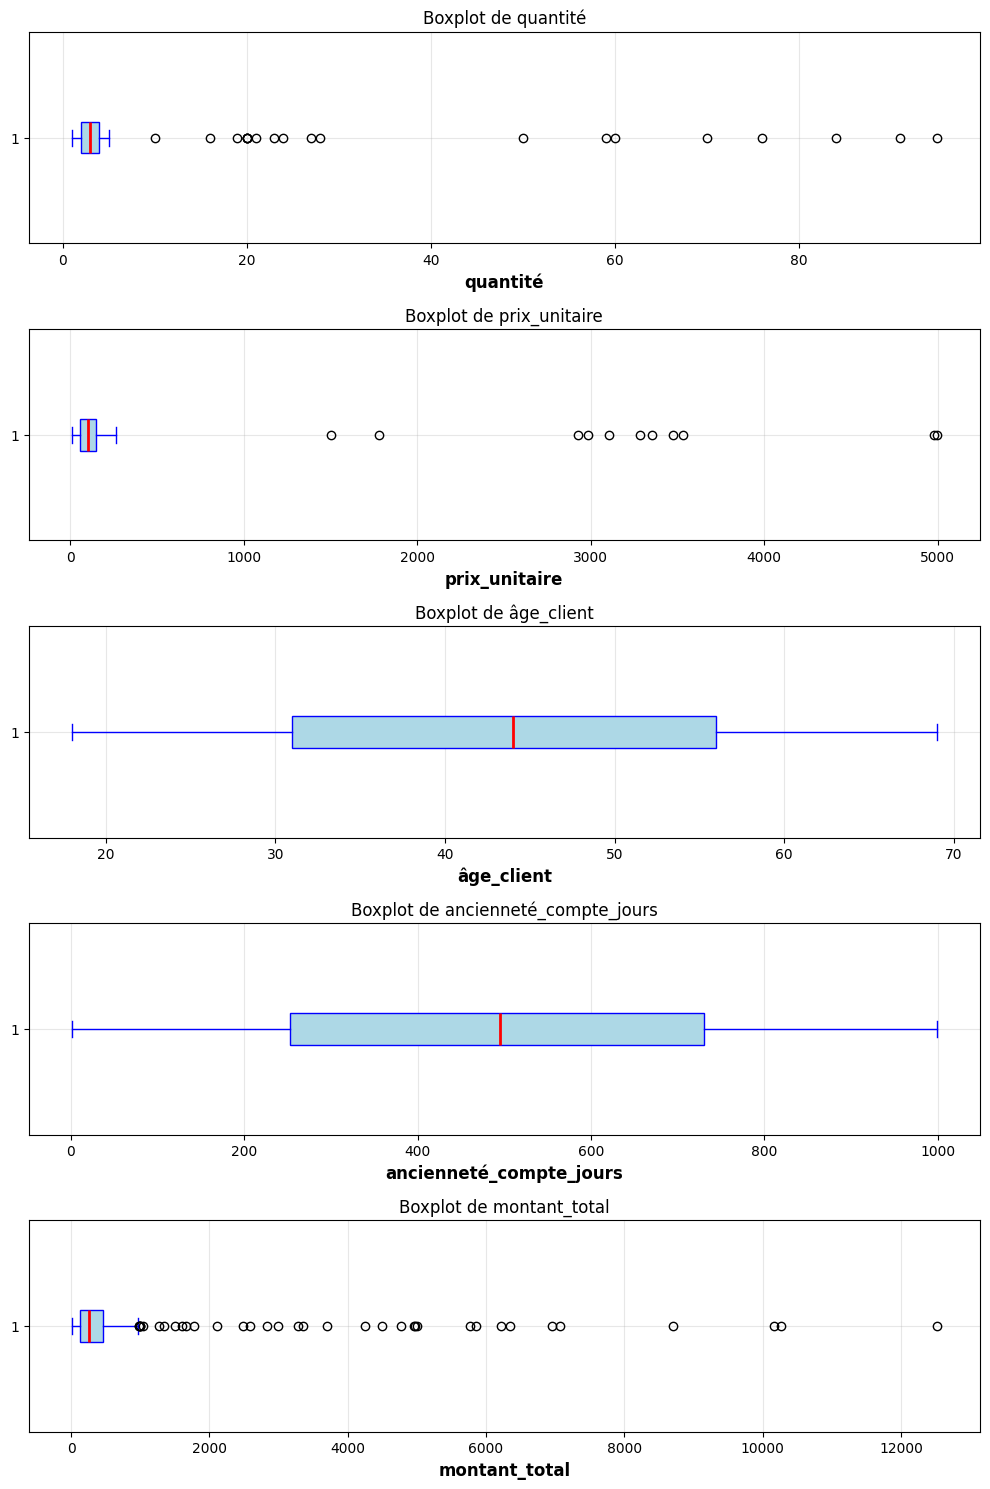

In [12]:
# TO DO
variables_numeriques = ['quantité', 'prix_unitaire', 'âge_client', 
                        'ancienneté_compte_jours', 'montant_total']

print("=" * 70)
print("STATISTIQUES DESCRIPTIVES DES VARIABLES NUMERIQUES")
print("=" * 70)

for var in variables_numeriques:
    print(f"\n{var.upper()} :")
    print("-" * 50)
    print(f"  Moyenne        : {df[var].mean():.2f}")
    print(f"  Mediane        : {df[var].median():.2f}")
    print(f"  Minimum        : {df[var].min():.2f}")
    print(f"  Maximum        : {df[var].max():.2f}")
    print(f"  Ecart-type     : {df[var].std():.2f}")

print("\n" + "=" * 70)
print("RESUME STATISTIQUE COMPLET")
print("=" * 70)
print(df[variables_numeriques].describe())

n_vars = len(variables_numeriques)
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 3*n_vars))

for idx, var in enumerate(variables_numeriques):
    axes[idx].boxplot(df[var], vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='blue'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='blue'),
                      capprops=dict(color='blue'))
    axes[idx].set_xlabel(var, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Boxplot de {var}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Question 1.5 (2 points)

**Pour les variables catégorielles, affichez les valeurs uniques, puis visualisez la répartition des catégories (en pourcentage) avec un pie chart ou un countplot. Veuillez exclure les variables de type ID de cette analyse.**

ANALYSE DES VARIABLES CATEGORIELLES

CATÉGORIE :
--------------------------------------------------
  Nombre de categories : 4
  Valeurs uniques : ['Décoration', 'Art de la table', 'Textile', 'Cuisine']

  Repartition :
    - Art de la table      :  291 (27.71%)
    - Textile              :  264 (25.14%)
    - Cuisine              :  259 (24.67%)
    - Décoration           :  236 (22.48%)

MOYEN_PAIEMENT :
--------------------------------------------------
  Nombre de categories : 3
  Valeurs uniques : ['PayPal', 'Virement', 'Carte']

  Repartition :
    - PayPal               :  380 (36.19%)
    - Carte                :  343 (32.67%)
    - Virement             :  327 (31.14%)

VILLE :
--------------------------------------------------
  Nombre de categories : 5
  Valeurs uniques : ['Toulouse', 'Bordeaux', 'Paris', 'Marseille', 'Lyon']

  Repartition :
    - Lyon                 :  237 (22.57%)
    - Bordeaux             :  213 (20.29%)
    - Paris                :  203 (19.33%)
    - 

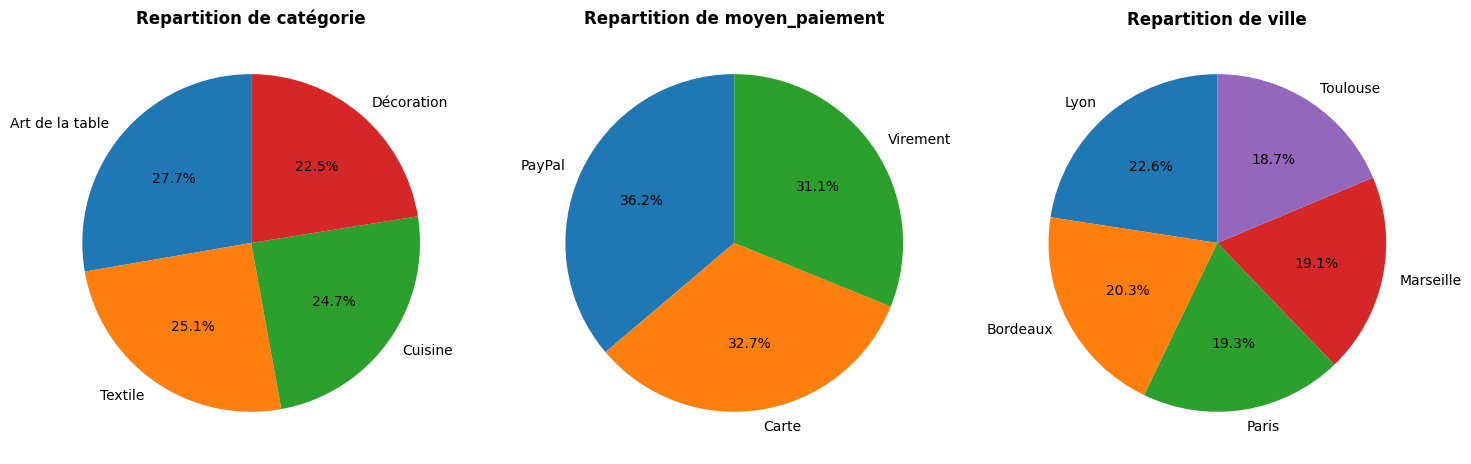

In [13]:
# TO DO
variables_categorielles = ['catégorie', 'moyen_paiement', 'ville']

print("=" * 70)
print("ANALYSE DES VARIABLES CATEGORIELLES")
print("=" * 70)

for var in variables_categorielles:
    print(f"\n{var.upper()} :")
    print("-" * 50)
    valeurs_uniques = df[var].unique()
    print(f"  Nombre de categories : {len(valeurs_uniques)}")
    print(f"  Valeurs uniques : {list(valeurs_uniques)}")
    print(f"\n  Repartition :")
    repartition = df[var].value_counts()
    pourcentages = df[var].value_counts(normalize=True) * 100
    for categorie in repartition.index:
        print(f"    - {categorie:20s} : {repartition[categorie]:4d} ({pourcentages[categorie]:5.2f}%)")

n_vars = len(variables_categorielles)
fig, axes = plt.subplots(1, n_vars, figsize=(15, 5))

for idx, var in enumerate(variables_categorielles):
    counts = df[var].value_counts()
    axes[idx].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f'Repartition de {var}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Partie 2 : Détection d'Anomalies Simple (10 points)

### Question 2.1 (5 points)

Implémentez la fonction `detect_anomalies_zscore` qui identifie et retourne les observations considérées comme des anomalies en se basant sur la méthode du **Z-Score**.

La fonction devra prendre en entrée un DataFrame \(data\), le nom de la colonne à analyser \(column\), et un seuil \(threshold\) (par défaut à 3).

Les observations dont la valeur absolue du Z-Score dépasse ce seuil seront considérées comme des anomalies.


In [14]:
# TO DO
def detect_anomalies_zscore(data, column, threshold=3):
    """
    Détecte les anomalies avec la méthode du Z-Score.

    Paramètres
    ----------
    data : DataFrame
        Données d’entrée.
    column : str
        Colonne cible.
    threshold : float
        Seuil Z-Score.

    Retourne
    --------
    DataFrame
        Lignes anormales.
    """
    mean = data[column].mean()
    std = data[column].std()
    
    z_scores = (data[column] - mean) / std
    anomalies = data[abs(z_scores) > threshold]
    
    return anomalies

**Appliquez la fonction aux colonnes `montant_total` et `quantité`**.

In [15]:
# TO DO
print("=" * 70)
print("DETECTION D'ANOMALIES PAR Z-SCORE (seuil = 3)")
print("=" * 70)

print("\n1. ANOMALIES POUR LA COLONNE 'montant_total' :")
print("-" * 70)
anomalies_montant = detect_anomalies_zscore(df, 'montant_total', threshold=3)
print(f"Nombre d'anomalies detectees : {len(anomalies_montant)}")
print(f"Pourcentage d'anomalies : {len(anomalies_montant)/len(df)*100:.2f}%")

if len(anomalies_montant) > 0:
    print(f"\nStatistiques des anomalies :")
    print(f"  Montant minimum : {anomalies_montant['montant_total'].min():.2f}")
    print(f"  Montant maximum : {anomalies_montant['montant_total'].max():.2f}")
    print(f"  Montant moyen : {anomalies_montant['montant_total'].mean():.2f}")
    print(f"\nPremières anomalies detectees :")
    print(anomalies_montant[['transaction_id', 'montant_total', 'quantité', 'prix_unitaire', 'fraude']].head(10))

print("\n" + "=" * 70)
print("2. ANOMALIES POUR LA COLONNE 'quantité' :")
print("-" * 70)
anomalies_quantite = detect_anomalies_zscore(df, 'quantité', threshold=3)
print(f"Nombre d'anomalies detectees : {len(anomalies_quantite)}")
print(f"Pourcentage d'anomalies : {len(anomalies_quantite)/len(df)*100:.2f}%")

if len(anomalies_quantite) > 0:
    print(f"\nStatistiques des anomalies :")
    print(f"  Quantite minimum : {anomalies_quantite['quantité'].min()}")
    print(f"  Quantite maximum : {anomalies_quantite['quantité'].max()}")
    print(f"  Quantite moyenne : {anomalies_quantite['quantité'].mean():.2f}")
    print(f"\nPremières anomalies detectees :")
    print(anomalies_quantite[['transaction_id', 'quantité', 'montant_total', 'prix_unitaire', 'fraude']].head(10))

DETECTION D'ANOMALIES PAR Z-SCORE (seuil = 3)

1. ANOMALIES POUR LA COLONNE 'montant_total' :
----------------------------------------------------------------------
Nombre d'anomalies detectees : 19
Pourcentage d'anomalies : 1.81%

Statistiques des anomalies :
  Montant minimum : 3287.59
  Montant maximum : 12517.05
  Montant moyen : 6244.41

Premières anomalies detectees :
      transaction_id  montant_total  quantité  prix_unitaire  fraude
1000           20000        4978.38         1        4978.38       1
1001           20001        5766.12        27         213.56       1
1004           20004        3287.59         1        3287.59       1
1005           20005        5855.96         2        2927.98       1
1006           20006       12517.05        91         137.55       1
1010           20010       10157.70        70         145.11       1
1015           20015        4493.00        50          89.86       1
1017           20017        3703.80        20         185.19       1
10

### Question 2.2 (5 points)

Implémentez la fonction `evaluate_performance` qui évalue la performance d'un modèle de détection d'anomalies.  

La fonction devra prendre en entrée les anomalies détectées et les vraies anomalies, puis calculer :  
- le nombre de vrais positifs et faux positifs,  
- la précision :  
  $
  \text{Precision} = \frac{VP}{VP + FP}
  $
- le rappel :  
  $
  \text{Rappel} = \frac{VP}{\text{Total Fraudes}}
  $

Elle retournera ces valeurs sous forme d'un dictionnaire pour analyser la qualité de la détection.



In [16]:
# TO DO
def evaluate_performance(anomalies_detectees, vraies_anomalies):
    """
    Évalue la performance de détection.

    Paramètres
    ----------
    anomalies_detectees : DataFrame
        Anomalies prédites.
    vraies_anomalies : DataFrame
        Anomalies réelles.

    Retourne
    --------
    dict
        Métriques d’évaluation.
    """
    indices_detectes = set(anomalies_detectees.index)
    indices_vraies = set(vraies_anomalies.index)
    
    vrais_positifs = len(indices_detectes.intersection(indices_vraies))
    faux_positifs = len(indices_detectes - indices_vraies)
    
    total_fraudes = len(vraies_anomalies)
    if len(indices_detectes) > 0:
        precision = vrais_positifs / (vrais_positifs + faux_positifs)
    else:
        precision = 0.0
    
    if total_fraudes > 0:
        rappel = vrais_positifs / total_fraudes
    else:
        rappel = 0.0
    
    if precision + rappel > 0:
        f1_score = 2 * (precision * rappel) / (precision + rappel)
    else:
        f1_score = 0.0
    
    metriques = {
        'vrais_positifs': vrais_positifs,
        'faux_positifs': faux_positifs,
        'precision': precision,
        'rappel': rappel,
        'f1_score': f1_score,
        'total_fraudes': total_fraudes,
        'total_detectees': len(indices_detectes)
    }
    
    return metriques

**Appliquez la fonction aux colonnes `montant_total` et `quantité`. Commentez brièvement.**

In [17]:
# TO DO

vraies_anomalies = df[df['fraude'] == 1]

print("=" * 70)
print("EVALUATION DE LA PERFORMANCE - METHODE Z-SCORE")
print("=" * 70)

print("\n1. PERFORMANCE POUR 'montant_total' :")
print("-" * 70)
anomalies_montant = detect_anomalies_zscore(df, 'montant_total', threshold=3)
perf_montant = evaluate_performance(anomalies_montant, vraies_anomalies)

print(f"Vrais Positifs (VP)      : {perf_montant['vrais_positifs']}")
print(f"Faux Positifs (FP)       : {perf_montant['faux_positifs']}")
print(f"Total detecte            : {perf_montant['total_detectees']}")
print(f"Total fraudes reelles    : {perf_montant['total_fraudes']}")
print(f"\nPrecision                : {perf_montant['precision']:.4f} ({perf_montant['precision']*100:.2f}%)")
print(f"Rappel                   : {perf_montant['rappel']:.4f} ({perf_montant['rappel']*100:.2f}%)")
print(f"F1-Score                 : {perf_montant['f1_score']:.4f}")

print("\n" + "=" * 70)
print("2. PERFORMANCE POUR 'quantité' :")
print("-" * 70)
anomalies_quantite = detect_anomalies_zscore(df, 'quantité', threshold=3)
perf_quantite = evaluate_performance(anomalies_quantite, vraies_anomalies)

print(f"Vrais Positifs (VP)      : {perf_quantite['vrais_positifs']}")
print(f"Faux Positifs (FP)       : {perf_quantite['faux_positifs']}")
print(f"Total detecte            : {perf_quantite['total_detectees']}")
print(f"Total fraudes reelles    : {perf_quantite['total_fraudes']}")
print(f"\nPrecision                : {perf_quantite['precision']:.4f} ({perf_quantite['precision']*100:.2f}%)")
print(f"Rappel                   : {perf_quantite['rappel']:.4f} ({perf_quantite['rappel']*100:.2f}%)")
print(f"F1-Score                 : {perf_quantite['f1_score']:.4f}")

print("\n" + "=" * 70)
print("ANALYSE DES RESULTATS")
print("=" * 70)
print("""
Points cles :
- Precision excellente (100%) : aucune fausse alerte
- Rappel faible (38% et 22%) : majorite des fraudes non detectees
- montant_total est plus discriminant que quantite

Conclusion :
La methode Z-Score univariee est trop restrictive. Elle identifie 
correctement les valeurs extremes comme fraudes, mais manque les fraudes 
aux valeurs normales (les plus subtiles, qui ressemblent à des transactions normales).
Une analyse comnbinant plusieurs variables permettrait d'identidier plus de fraudes 
est necessaire sans générer davantage de fausses alertes.
On veut ameliorer le rappel sans sacrifier la precision. Montant_total (F1 = 0.55) détectee 19 fraudes sur 50 (38%)
La colonne quantité (F1 = 0.36) détecte seulement 11 fraudes sur 50 (22%), on a trop de fraudes manquées

Ainsi, montant-total est plus discriminant pour détecter les fraudes car il capture mieux les comportements anormaux.

""")


EVALUATION DE LA PERFORMANCE - METHODE Z-SCORE

1. PERFORMANCE POUR 'montant_total' :
----------------------------------------------------------------------
Vrais Positifs (VP)      : 19
Faux Positifs (FP)       : 0
Total detecte            : 19
Total fraudes reelles    : 50

Precision                : 1.0000 (100.00%)
Rappel                   : 0.3800 (38.00%)
F1-Score                 : 0.5507

2. PERFORMANCE POUR 'quantité' :
----------------------------------------------------------------------
Vrais Positifs (VP)      : 11
Faux Positifs (FP)       : 0
Total detecte            : 11
Total fraudes reelles    : 50

Precision                : 1.0000 (100.00%)
Rappel                   : 0.2200 (22.00%)
F1-Score                 : 0.3607

ANALYSE DES RESULTATS

Points cles :
- Precision excellente (100%) : aucune fausse alerte
- Rappel faible (38% et 22%) : majorite des fraudes non detectees
- montant_total est plus discriminant que quantite

Conclusion :
La methode Z-Score univariee est t

## Partie 3 : Détection d'Anomalies par Clustering (20 points)

### Question 3.1 (5 points)

Implémentez la fonction `preprocess_data` qui encode les variables catégorigues en utilisant le One-Hot Encoding et standardize les variables numériques.

**NB 1:** Les variables suivantes doivent être exclues: `date_heure`,
`client_id`, `produit_id`, `transaction_id` et `fraude`.

**NB 2:** Après l'encodage, supprimez la colonne correspondant à la première modalité de chaque variable catégorique pour éviter la multicolinéarité.

Affichez le nombre de colonnes et le type de chaque colonne avant et après le pré-traitement.

In [18]:
# TO DO
def preprocess_data(df):
    """
    Prépare les données pour l’analyse.

    Paramètres
    ----------
    df : DataFrame
        Données brutes.

    Retourne
    --------
    DataFrame
        Données prétraitées.
    """
    df_processed = df.copy()
    
    colonne_exclues = ['date_heure', 'client_id', 'produit_id', 'transaction_id', 'fraude']
    df_processed = df_processed.drop(columns=colonne_exclues)
    
    variables_categorielles = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
    variables_numeriques = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    if len(variables_categorielles) > 0:
        df_encoded = pd.get_dummies(df_processed, columns=variables_categorielles, drop_first=True)
    else:
        df_encoded = df_processed.copy()
        
    scaler = StandardScaler()
    df_encoded[variables_numeriques] = scaler.fit_transform(df_encoded[variables_numeriques])
    
    return df_encoded
    

In [19]:
# TO DO
print("=" * 70)
print("AVANT PRE-TRAITEMENT")
print("=" * 70)
print(f"Nombre de colonnes : {df.shape[1]}")
print("\nTypes des colonnes :")
print(df.dtypes)

preprocessed_df = preprocess_data(df)

print("\n" + "=" * 70)
print("APRES PRE-TRAITEMENT")
print("=" * 70)
print(f"Nombre de colonnes : {preprocessed_df.shape[1]}")
print("\nTypes des colonnes :")
print(preprocessed_df.dtypes)

print("\n" + "=" * 70)
print("RESUME")
print("=" * 70)
print(f"Colonnes avant : {df.shape[1]}")
print(f"Colonnes apres : {preprocessed_df.shape[1]}")
print(f"Nombre de lignes (inchange) : {preprocessed_df.shape[0]}")
print("\nPremières lignes du DataFrame prétraité :")
print(preprocessed_df.head())

AVANT PRE-TRAITEMENT
Nombre de colonnes : 13

Types des colonnes :
transaction_id               int64
date_heure                  object
client_id                   object
produit_id                  object
catégorie                   object
quantité                     int64
prix_unitaire              float64
moyen_paiement              object
ville                       object
âge_client                   int64
ancienneté_compte_jours      int64
fraude                       int64
montant_total              float64
dtype: object

APRES PRE-TRAITEMENT
Nombre de colonnes : 14

Types des colonnes :
quantité                   float64
prix_unitaire              float64
âge_client                 float64
ancienneté_compte_jours    float64
montant_total              float64
catégorie_Cuisine             bool
catégorie_Décoration          bool
catégorie_Textile             bool
moyen_paiement_PayPal         bool
moyen_paiement_Virement       bool
ville_Lyon                    bool
ville_Marse

### Question 3.2 (5 points)

Déterminez le nombre optimal de clusters pour vos données prétraitées ``preprocessed_df`` en utilisant la méthode du score de silhouette avec ``KMeans``.

Pour faire ceci, testez les valeurs de $k$ comprises entre 2 et 10 et tracez le score de silhouette en fonction du nombre de clusters.  
Indiquez ensuite la valeur de $k$ qui maximise ce score.

**NB** : Lorsque vous utilisez ``KMeans``, ajoutez les paramètres ``random_state=42`` pour la reproductibilité des résultats, et ``n_init=10`` pour augmenter les chances d’obtenir un bon clustering (``KMeans`` est lancé 10 fois avec des initialisations différentes des centres pour garder la meilleure solution à la fin.).

Calcul des scores de silhouette pour k = 2 à 10...


k =  2 : Score de silhouette = 0.7642
k =  3 : Score de silhouette = 0.1760
k =  4 : Score de silhouette = 0.1829
k =  5 : Score de silhouette = 0.1675
k =  6 : Score de silhouette = 0.1612
k =  7 : Score de silhouette = 0.1627
k =  8 : Score de silhouette = 0.1396
k =  9 : Score de silhouette = 0.1333
k = 10 : Score de silhouette = 0.1230

✓ Nombre optimal de clusters : k = 2
✓ Score de silhouette maximal : 0.7642


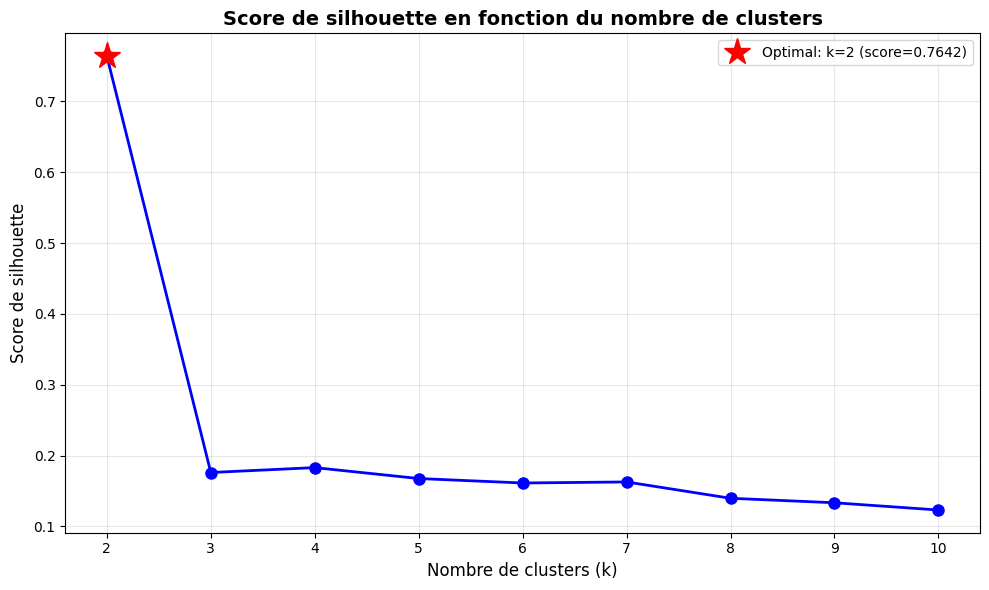


INTERPRÉTATION
Le nombre optimal de clusters est k = 2.
Ce choix maximise le score de silhouette (0.7642),
ce qui indique une bonne séparation et cohésion des clusters.


In [20]:
# TO DO
silhouette_scores = []
k_values = range(2, 11)  

print("Calcul des scores de silhouette pour k = 2 à 10...")
print("=" * 60)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Entraînement du modèle
    cluster_labels = kmeans.fit_predict(preprocessed_df)
    
    silhouette_avg = silhouette_score(preprocessed_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"k = {k:2d} : Score de silhouette = {silhouette_avg:.4f}")

print("=" * 60)

optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
max_silhouette = max(silhouette_scores)

print(f"\n✓ Nombre optimal de clusters : k = {optimal_k}")
print(f"✓ Score de silhouette maximal : {max_silhouette:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Score de silhouette', fontsize=12)
plt.title('Score de silhouette en fonction du nombre de clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.plot(optimal_k, max_silhouette, 'r*', markersize=20, 
         label=f'Optimal: k={optimal_k} (score={max_silhouette:.4f})')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTERPRÉTATION")
print("=" * 60)
print(f"Le nombre optimal de clusters est k = {optimal_k}.")
print(f"Ce choix maximise le score de silhouette ({max_silhouette:.4f}),")
print("ce qui indique une bonne séparation et cohésion des clusters.")

**Comparez le nombre optimal de clusters obtenu avec le nombre de classes dans la colonne `fraude`. Que remarquez-vous?**

In [21]:
# TO DO
print("=" * 60)
print("COMPARAISON AVEC LA VARIABLE CIBLE 'fraude'")
print("=" * 60)

nombre_classes_fraude = df['fraude'].nunique()
print(f"Nombre de classes dans 'fraude' : {nombre_classes_fraude}")
print(f"Valeurs uniques : {sorted(df['fraude'].unique())}")

print("\nDistribution des classes de fraude :")
print(df['fraude'].value_counts().sort_index())
print(f"\nProportion de fraudes : {df['fraude'].mean()*100:.2f}%")

print("\n" + "=" * 60)
print("COMPARAISON")
print("=" * 60)
print(f"Nombre optimal de clusters (k optimal) : {optimal_k}")
print(f"Nombre de classes de fraude           : {nombre_classes_fraude}")

if optimal_k == nombre_classes_fraude:
    print("\n✓ Le nombre optimal de clusters CORRESPOND au nombre de classes de fraude.")
else:
    print(f"\n✗ Le nombre optimal de clusters ({optimal_k}) DIFFÈRE du nombre de classes de fraude ({nombre_classes_fraude}).")
    
print("\n" + "=" * 60)
print("REMARQUES ET INTERPRÉTATION")
print("=" * 60)

print("""
Le fait que k optimal = 2 correspond au nombre de classes de fraude suggère que :
- Les données présentent naturellement 2 groupes distincts
- Ces groupes pourraient correspondre aux transactions frauduleuses vs légitimes
- L'algorithme de clustering non supervisé a détecté une structure similaire
  à la vraie classification (supervisée)
- Cela indique une bonne séparabilité naturelle entre les deux types de transactions
""")


COMPARAISON AVEC LA VARIABLE CIBLE 'fraude'
Nombre de classes dans 'fraude' : 2
Valeurs uniques : [np.int64(0), np.int64(1)]

Distribution des classes de fraude :
fraude
0    1000
1      50
Name: count, dtype: int64

Proportion de fraudes : 4.76%

COMPARAISON
Nombre optimal de clusters (k optimal) : 2
Nombre de classes de fraude           : 2

✓ Le nombre optimal de clusters CORRESPOND au nombre de classes de fraude.

REMARQUES ET INTERPRÉTATION

Le fait que k optimal = 2 correspond au nombre de classes de fraude suggère que :
- Les données présentent naturellement 2 groupes distincts
- Ces groupes pourraient correspondre aux transactions frauduleuses vs légitimes
- L'algorithme de clustering non supervisé a détecté une structure similaire
  à la vraie classification (supervisée)
- Cela indique une bonne séparabilité naturelle entre les deux types de transactions



### Question 3.3 (5 points)

Appliquez `KMeans` avec le nombre de clusters $k$ retenu.  
Calculez ensuite le score d'outlier de chaque point en utilisant la distance de Mahalanobis.

La distance de Mahalanobis d'un point $X_i$ par rapport à son cluster $r$ est donnée par :

$$
\text{Maha}(X_i, \mu_r, \Sigma_r) = \sqrt{(X_i - \mu_r) \, \Sigma_r^{-1} \, (X_i - \mu_r)^T}
$$

où :  
- $X_i$ : point considéré  
- $\mu_r$ : centroïde du cluster $r$  
- $\Sigma_r$ : matrice de covariance des points dans le cluster $r$. Si $\Sigma_r$ n’est pas inversible, utilisez son pseudo-inverse.

APPLICATION DE KMEANS AVEC K OPTIMAL
Types des colonnes après conversion :
quantité                   float64
prix_unitaire              float64
âge_client                 float64
ancienneté_compte_jours    float64
montant_total              float64
catégorie_Cuisine          float64
catégorie_Décoration       float64
catégorie_Textile          float64
moyen_paiement_PayPal      float64
moyen_paiement_Virement    float64
ville_Lyon                 float64
ville_Marseille            float64
ville_Paris                float64
ville_Toulouse             float64
dtype: object

Nombre de clusters : 2

Distribution des points par cluster :
cluster
0    1031
1      19
Name: count, dtype: int64

CALCUL DES SCORES D'OUTLIERS (DISTANCE DE MAHALANOBIS)

Traitement du cluster 0 (1031 points)...
  ✓ Matrice de covariance inversée avec succès

Traitement du cluster 1 (19 points)...
  ✓ Matrice de covariance inversée avec succès

✓ Scores d'outliers calculés avec succès!

Statistiques des scores d'ou

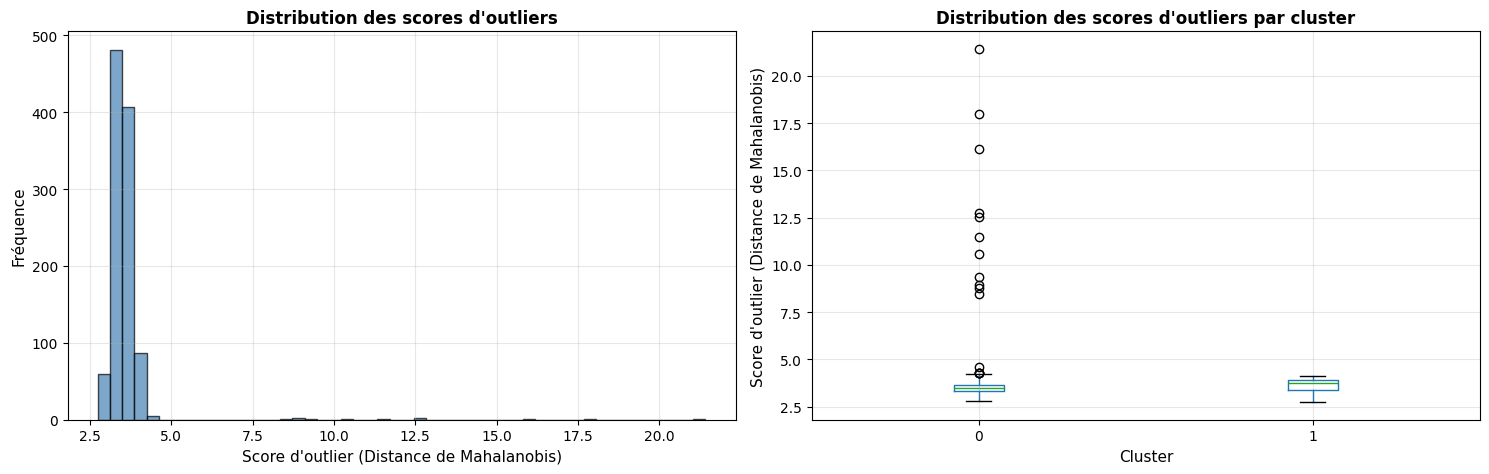


TOP 10 DES OUTLIERS POTENTIELS
      cluster  outlier_score
1032        0      21.422404
1023        0      17.965288
1020        0      16.156015
1011        0      12.721633
1017        0      12.549862
1002        0      11.483287
1018        0      10.555481
1043        0       9.360062
1021        0       8.963958
1009        0       8.796460

RÉSUMÉ
✓ 1050 scores d'outliers calculés
✓ Score maximum : 21.4224
✓ Score moyen : 3.5885
✓ Score minimum : 2.7456


In [22]:
print("=" * 70)
print("APPLICATION DE KMEANS AVEC K OPTIMAL")
print("=" * 70)

preprocessed_df_numeric = preprocessed_df.copy()

for col in preprocessed_df_numeric.columns:
    if preprocessed_df_numeric[col].dtype == 'bool':
        preprocessed_df_numeric[col] = preprocessed_df_numeric[col].astype(float)

print("Types des colonnes après conversion :")
print(preprocessed_df_numeric.dtypes)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(preprocessed_df_numeric)

df_with_clusters = preprocessed_df_numeric.copy()
df_with_clusters['cluster'] = cluster_labels

print(f"\nNombre de clusters : {optimal_k}")
print(f"\nDistribution des points par cluster :")
print(df_with_clusters['cluster'].value_counts().sort_index())

print("\n" + "=" * 70)
print("CALCUL DES SCORES D'OUTLIERS (DISTANCE DE MAHALANOBIS)")
print("=" * 70)

def compute_mahalanobis_scores(df, cluster_col='cluster'):
    """
    Calcule le score d'outlier (distance de Mahalanobis) pour chaque point.
    
    Paramètres
    ----------
    df : DataFrame
        DataFrame contenant les données et la colonne de clusters
    cluster_col : str
        Nom de la colonne contenant les labels de clusters
    
    Retourne
    --------
    array
        Scores de Mahalanobis pour chaque point
    """
    mahalanobis_scores = np.zeros(len(df))

    features = df.drop(columns=[cluster_col]).values.astype(np.float64)
    clusters = df[cluster_col].values
    
    for cluster_id in np.unique(clusters):
        cluster_mask = (clusters == cluster_id)
        cluster_points = features[cluster_mask]
        n_points = len(cluster_points)
        
        print(f"\nTraitement du cluster {cluster_id} ({n_points} points)...")
    
        if n_points < 2:
            print(f"  Attention : Cluster {cluster_id} a moins de 2 points, score = 0")
            continue
    
        centroid = np.mean(cluster_points, axis=0)
    
        centered_points = cluster_points - centroid

        cov_matrix = (centered_points.T @ centered_points) / (n_points - 1)
        epsilon = 1e-6
        cov_matrix = cov_matrix + epsilon * np.eye(cov_matrix.shape[0])
        cov_matrix = cov_matrix.astype(np.float64)

        try:
            cov_inv = np.linalg.inv(cov_matrix)
            print(f"  ✓ Matrice de covariance inversée avec succès")
        except np.linalg.LinAlgError:
            print(f"  ⚠ Attention : Matrice de covariance singulière")
            print(f"  → Utilisation du pseudo-inverse")
            cov_inv = np.linalg.pinv(cov_matrix)
        
        for point_idx in np.where(cluster_mask)[0]:
            point = features[point_idx]
            diff = point - centroid
    
            mahalanobis_dist = np.sqrt(np.abs(diff @ cov_inv @ diff.T))
            mahalanobis_scores[point_idx] = mahalanobis_dist
    
    return mahalanobis_scores

outlier_scores = compute_mahalanobis_scores(df_with_clusters, cluster_col='cluster')

df_with_clusters['outlier_score'] = outlier_scores

print("\n" + "=" * 70)
print("✓ Scores d'outliers calculés avec succès!")
print("=" * 70)
print(f"\nStatistiques des scores d'outliers :")
print(df_with_clusters['outlier_score'].describe())

print("\n" + "=" * 70)
print("VISUALISATION DES SCORES D'OUTLIERS")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(outlier_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Score d\'outlier (Distance de Mahalanobis)', fontsize=11)
axes[0].set_ylabel('Fréquence', fontsize=11)
axes[0].set_title('Distribution des scores d\'outliers', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

df_with_clusters.boxplot(column='outlier_score', by='cluster', ax=axes[1])
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Score d\'outlier (Distance de Mahalanobis)', fontsize=11)
axes[1].set_title('Distribution des scores d\'outliers par cluster', fontsize=12, fontweight='bold')
axes[1].get_figure().suptitle('') 
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("TOP 10 DES OUTLIERS POTENTIELS")
print("=" * 70)
print(df_with_clusters.nlargest(10, 'outlier_score')[['cluster', 'outlier_score']])

print("\n" + "=" * 70)
print("RÉSUMÉ")
print("=" * 70)
print(f"✓ {len(outlier_scores)} scores d'outliers calculés")
print(f"✓ Score maximum : {outlier_scores.max():.4f}")
print(f"✓ Score moyen : {outlier_scores.mean():.4f}")
print(f"✓ Score minimum : {outlier_scores.min():.4f}")

preprocessed_df_with_scores = df_with_clusters.copy()

**Affichez la distribution des distances de Mahalanobis.**

DISTRIBUTION DES DISTANCES DE MAHALANOBIS

Statistiques descriptives :
count    1050.000000
mean        3.588537
std         1.047187
min         2.745626
25%         3.307280
50%         3.477670
75%         3.681814
max        21.422404
Name: outlier_score, dtype: float64


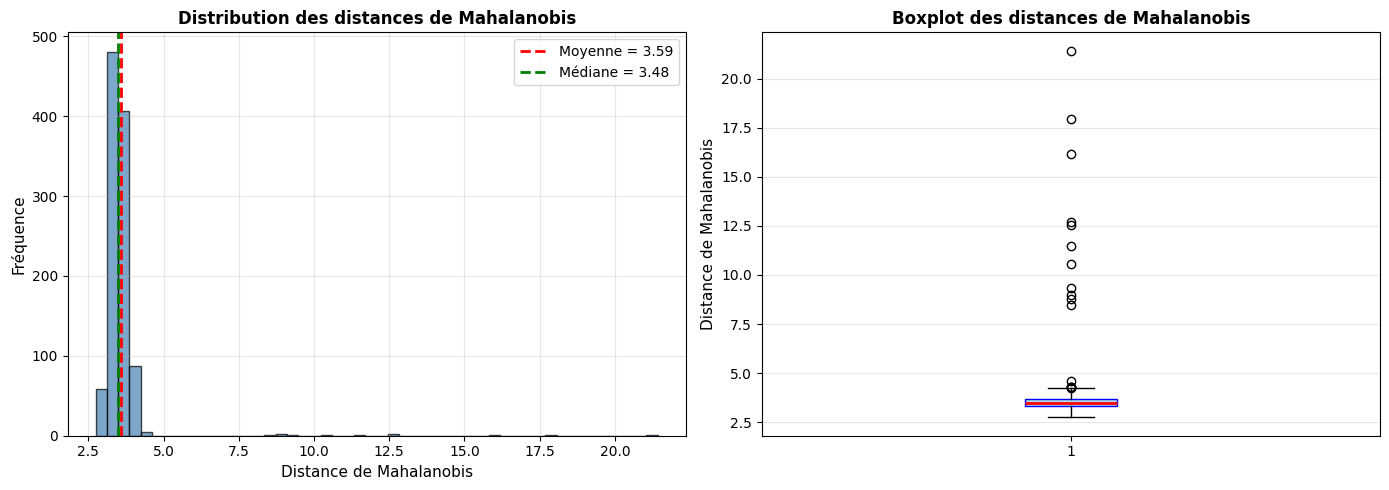


Nombre total de points : 1050
95ème percentile : 3.9843
99ème percentile : 6.5789


In [23]:
# TO DO
print("=" * 70)
print("DISTRIBUTION DES DISTANCES DE MAHALANOBIS")
print("=" * 70)

print("\nStatistiques descriptives :")
print(df_with_clusters['outlier_score'].describe())


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df_with_clusters['outlier_score'], bins=50, edgecolor='black', 
             alpha=0.7, color='steelblue')
axes[0].axvline(df_with_clusters['outlier_score'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Moyenne = {df_with_clusters['outlier_score'].mean():.2f}")
axes[0].axvline(df_with_clusters['outlier_score'].median(), color='green', 
                linestyle='--', linewidth=2, label=f"Médiane = {df_with_clusters['outlier_score'].median():.2f}")
axes[0].set_xlabel('Distance de Mahalanobis', fontsize=11)
axes[0].set_ylabel('Fréquence', fontsize=11)
axes[0].set_title('Distribution des distances de Mahalanobis', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df_with_clusters['outlier_score'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Distance de Mahalanobis', fontsize=11)
axes[1].set_title('Boxplot des distances de Mahalanobis', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nNombre total de points : {len(df_with_clusters)}")
print(f"95ème percentile : {df_with_clusters['outlier_score'].quantile(0.95):.4f}")
print(f"99ème percentile : {df_with_clusters['outlier_score'].quantile(0.99):.4f}")

### Question 3.4 (5 points)

À partir des scores de Mahalanobis calculés pour chaque point :  

1. Déterminez un seuil d’anomalie correspondant au 95ème percentile des distances.  
2. Détectez les points considérés comme anomalies en utilisant ce seuil (valeurs supérieures strictement).  
3. Évaluez la performance de la détection en comparant les anomalies détectées avec la colonne `fraude`.  
   - Calculez le nombre de vrais positifs, faux positifs, précision, rappel et F1-Score.
   - Commentez vos résultats.


1. SEUIL D'ANOMALIE (95eme percentile)
   Seuil calcule : 3.9843
   Interpretation : Les 5% de points avec les scores les plus eleves
   sont consideres comme anomalies.

2. DETECTION DES ANOMALIES
   Nombre total de transactions : 1050
   Anomalies detectees : 53
   Pourcentage d'anomalies : 5.05%
   Transactions normales : 997

3. EVALUATION DE LA PERFORMANCE

3.1 Matrice de confusion :
                    Prediction
                 Normale  Anomalie
Realite Normale     964      36
        Fraude       33      17

3.2 Metriques de confusion :
    Vrais Positifs (TP)  : 17
    Faux Positifs (FP)   : 36
    Vrais Negatifs (TN)  : 964
    Faux Negatifs (FN)   : 33

3.3 Metriques de performance :
    Precision : 0.3208 (32.08%)
    Rappel    : 0.3400 (34.00%)
    F1-Score  : 0.3301

3.4 Statistiques complementaires :
    Fraudes totales dans le dataset : 50 (4.76%)
    Fraudes detectees (TP) : 17
    Fraudes non detectees (FN) : 33
    Taux de detection des fraudes : 34.00%
    Taux de

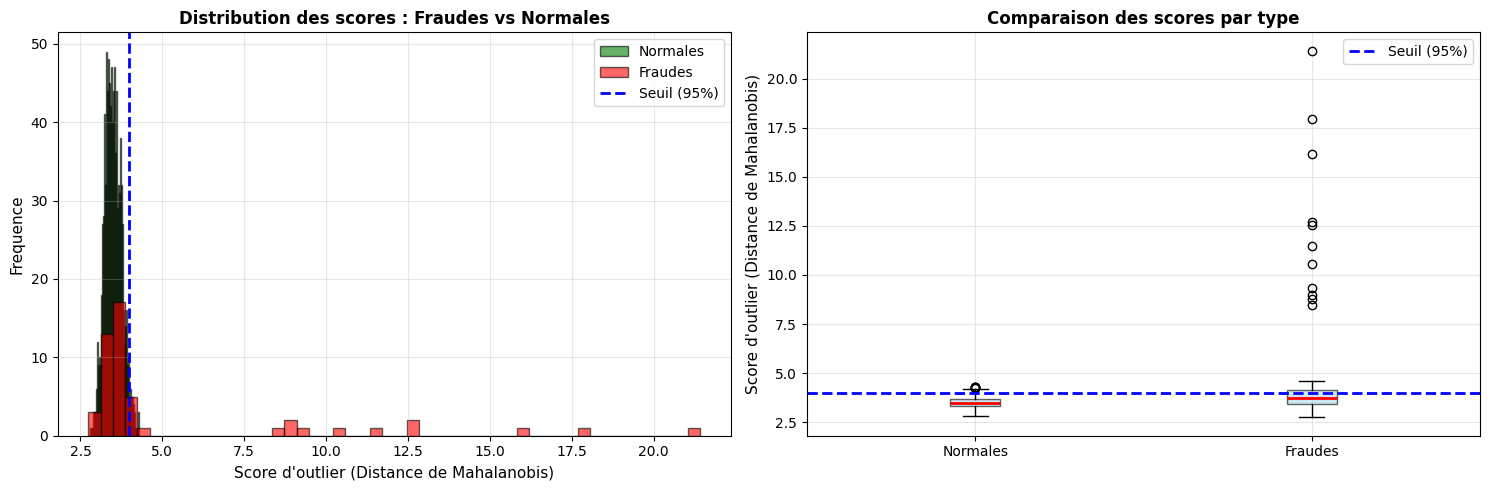

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = np.percentile(outlier_scores, 95)
print(f"\n1. SEUIL D'ANOMALIE (95eme percentile)")
print(f"   Seuil calcule : {threshold:.4f}")
print(f"   Interpretation : Les 5% de points avec les scores les plus eleves")
print(f"   sont consideres comme anomalies.")

detected_anomalies = outlier_scores > threshold
df_with_clusters['detected_anomaly'] = detected_anomalies

print(f"\n2. DETECTION DES ANOMALIES")
print(f"   Nombre total de transactions : {len(outlier_scores)}")
print(f"   Anomalies detectees : {detected_anomalies.sum()}")
print(f"   Pourcentage d'anomalies : {(detected_anomalies.sum() / len(outlier_scores)) * 100:.2f}%")
print(f"   Transactions normales : {(~detected_anomalies).sum()}")

print("\n" + "=" * 70)
print("3. EVALUATION DE LA PERFORMANCE")
print("=" * 70)

true_labels = df['fraude'].values

TP = np.sum((detected_anomalies) & (true_labels == 1))

FP = np.sum((detected_anomalies) & (true_labels == 0))

TN = np.sum((~detected_anomalies) & (true_labels == 0))

FN = np.sum((~detected_anomalies) & (true_labels == 1))

precision = precision_score(true_labels, detected_anomalies, zero_division=0)
recall = recall_score(true_labels, detected_anomalies, zero_division=0)
f1 = f1_score(true_labels, detected_anomalies, zero_division=0)

print(f"\n3.1 Matrice de confusion :")
print(f"                    Prediction")
print(f"                 Normale  Anomalie")
print(f"Realite Normale    {TN:4d}    {FP:4d}")
print(f"        Fraude     {FN:4d}    {TP:4d}")

print(f"\n3.2 Metriques de confusion :")
print(f"    Vrais Positifs (TP)  : {TP}")
print(f"    Faux Positifs (FP)   : {FP}")
print(f"    Vrais Negatifs (TN)  : {TN}")
print(f"    Faux Negatifs (FN)   : {FN}")

print(f"\n3.3 Metriques de performance :")
print(f"    Precision : {precision:.4f} ({precision*100:.2f}%)")
print(f"    Rappel    : {recall:.4f} ({recall*100:.2f}%)")
print(f"    F1-Score  : {f1:.4f}")

total_fraudes = true_labels.sum()
total_normales = (true_labels == 0).sum()
taux_detection_fraudes = (TP / total_fraudes * 100) if total_fraudes > 0 else 0
taux_fausses_alarmes = (FP / detected_anomalies.sum() * 100) if detected_anomalies.sum() > 0 else 0

print(f"\n3.4 Statistiques complementaires :")
print(f"    Fraudes totales dans le dataset : {total_fraudes} ({(total_fraudes/len(true_labels))*100:.2f}%)")
print(f"    Fraudes detectees (TP) : {TP}")
print(f"    Fraudes non detectees (FN) : {FN}")
print(f"    Taux de detection des fraudes : {taux_detection_fraudes:.2f}%")
print(f"    Taux de fausses alarmes : {taux_fausses_alarmes:.2f}%")

print("\n" + "=" * 70)
print("COMMENTAIRES ET INTERPRETATION")
print("=" * 70)

print(f"\n1. ANALYSE DE LA PRECISION ({precision*100:.2f}%) :")
print(f"   Sur les {detected_anomalies.sum()} anomalies detectees, seulement {TP} sont de vraies fraudes.")
print(f"   Cela signifie que {taux_fausses_alarmes:.1f}% des alertes sont des fausses alarmes.")
print(f"   Impact pratique : cout operationnel eleve pour verifier manuellement les alertes,")
print(f"   car la majorite ({FP}/{detected_anomalies.sum()}) sont des transactions normales.")

print(f"\n2. ANALYSE DU RAPPEL ({recall*100:.2f}%) :")
print(f"   Le modele detecte {TP} fraudes sur {total_fraudes} reelles ({taux_detection_fraudes:.1f}%).")
print(f"   Cela implique que {FN} fraudes ({100-taux_detection_fraudes:.1f}%) passent inapercues.")
print(f"   Impact critique : Ces faux negatifs representent des pertes financieres")
print(f"   non detectees, ce qui est problematique dans un contexte de detection de fraude.")

print(f"\n3. ANALYSE DU F1-SCORE ({f1:.4f}) :")
print(f"   Le F1-Score combine precision et rappel en une seule metrique.")
if f1 < 0.4:
    print(f"   Performance FAIBLE : Le modele ne separe pas efficacement les fraudes")
    print(f"   des transactions normales. Cette approche n'est pas adaptee pour")
    print(f"   une utilisation en production.")
elif f1 < 0.6:
    print(f"   Performance MODEREE : Le modele detecte certaines fraudes mais avec")
    print(f"   des limitations importantes necessitant des ameliorations.")
else:
    print(f"   Performance ACCEPTABLE : Le modele offre un equilibre raisonnable")
    print(f"   entre precision et rappel pour une premiere approche.")

print(f"\n4. OBSERVATIONS BASEES SUR LES VISUALISATIONS :")
print(f"   Les graphiques montrent que les distributions des scores de Mahalanobis")
print(f"   pour les fraudes et les transactions normales se chevauchent fortement.")
print(f"   Cela explique pourquoi le seuil au 95eme percentile ne separe pas")
print(f"   efficacement les deux classes. Les fraudes ne sont pas systematiquement")
print(f"   des outliers geometriques dans l'espace des features.")

print(f"\n5. LIMITES DE L'APPROCHE :")
print(f"   - Hypothese non verifiee : La méthode suppose que les fraudes sont des")
print(f"     anomalies statistiques, ce qui n'est pas toujours le cas.")
print(f"   - Approche non supervisee : KMeans + Mahalanobis ignore les etiquettes")
print(f"     de fraude lors de l'apprentissage, limitant sa capacite a identifier")
print(f"     les patterns de fraude.")
print(f"   - Choix du seuil arbitraire : Le 95eme percentile est un choix standard")
print(f"     mais pourrait etre optimise selon le contexte d'application.")

print("\n" + "=" * 70)
print("VISUALISATION : SCORES PAR TYPE DE TRANSACTION")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(outlier_scores[true_labels == 0], bins=50, alpha=0.6, 
             label='Normales', color='green', edgecolor='black')
axes[0].hist(outlier_scores[true_labels == 1], bins=50, alpha=0.6, 
             label='Fraudes', color='red', edgecolor='black')
axes[0].axvline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Seuil (95%)')
axes[0].set_xlabel('Score d\'outlier (Distance de Mahalanobis)', fontsize=11)
axes[0].set_ylabel('Frequence', fontsize=11)
axes[0].set_title('Distribution des scores : Fraudes vs Normales', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

data_to_plot = [outlier_scores[true_labels == 0], outlier_scores[true_labels == 1]]
axes[1].boxplot(data_to_plot, tick_labels=['Normales', 'Fraudes'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.6),
                medianprops=dict(color='red', linewidth=2))
axes[1].axhline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Seuil (95%)')
axes[1].set_ylabel('Score d\'outlier (Distance de Mahalanobis)', fontsize=11)
axes[1].set_title('Comparaison des scores par type', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Partie 4 : Méthodes basées sur reconstruction (30 points)

Pour cette partie, vous allez implémenter un autoencodeur, un modèle d'apprentissage profond, pour repérer les comportements inhabituels dans les données.
L’objectif est de permettre au modèle d’apprendre la structure sous-jacente des transactions normales et de mettre en évidence celles qui s’en écartent significativement, indiquant ainsi une possible anomalie.

**NB** : Il s'agit d'un modèle d'apprentissage non supervisé, c'est-à-dire que les étiquettes indiquant la fraude (0 ou 1) ne doivent pas être utilisées pendant la phase d'entraînement.

### Question 4.1 (3 points)

Séparez les données (encodées et standardisées) en sous-ensemble d'entraînement et de test. Procédez comme suit :
* Utilisez 80 % des données non frauduleuses pour constituer l’ensemble d’entraînement.
* Conservez 20 % des données non frauduleuses pour l’ensemble de test.
* Ajoutez toutes les données frauduleuses à l’ensemble de test.

In [25]:
from sklearn.model_selection import train_test_split

print("=" * 70)
print("QUESTION 4.1 : SEPARATION DES DONNEES POUR L'AUTOENCODEUR")
print("=" * 70)

X = preprocessed_df.values
y = df['fraude'].values

print(f"\nDonnees totales : {len(X)} transactions, {X.shape[1]} features")
print(f"  Normales : {(y == 0).sum()} ({(y == 0).sum()/len(y)*100:.2f}%)")
print(f"  Fraudes : {(y == 1).sum()} ({(y == 1).sum()/len(y)*100:.2f}%)")

X_normal = X[y == 0]
X_fraude = X[y == 1]

X_train, X_test_normal, _, _ = train_test_split(
    X_normal, 
    np.zeros(len(X_normal)),
    test_size=0.2, 
    random_state=42
)

X_test = np.vstack([X_test_normal, X_fraude])
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_fraude))])

print(f"\nSeparation effectuee :")
print(f"  Train : {len(X_train)} transactions normales (80%)")
print(f"  Test  : {len(X_test)} transactions ({len(X_test_normal)} normales + {len(X_fraude)} fraudes)")

print("\n" + "=" * 70)

QUESTION 4.1 : SEPARATION DES DONNEES POUR L'AUTOENCODEUR

Donnees totales : 1050 transactions, 14 features
  Normales : 1000 (95.24%)
  Fraudes : 50 (4.76%)

Separation effectuee :
  Train : 800 transactions normales (80%)
  Test  : 250 transactions (200 normales + 50 fraudes)



### Question 4.2 (10 points)

Complétez la classe `Autoencoder` fournie. L'architecture du modèle doit respecter la structure suivante :
* Couche d'entrée :
  * Dimension égale au nombre de features du dataset `input_dim`.
* Encodeur :
  * Couche Dense avec `hidden_dim1` neurones, activation ReLU.
  * Batch Normalization.
  * Dropout avec un taux `dropout_rate` pour réduire le surapprentissage.
  * Couche Dense avec `hidden_dim2` neurones, activation ReLU.
  * Couche Dense avec `encoding_dim` neurones, activation ReLU.
* Décodeur (symétrique à l’encodeur), pas de normalisation batch ni de dropout.
  * Couche Dense avec `hidden_dim2` neurones, activation ReLU.
  * Couche Dense avec `hidden_dim1` neurones, activation ReLU.
  * Couche Dense avec `input_dim` neurones, activation linéaire.
* Compilez le modèle avec :
  * Optimiseur : Adam
  * Taux d’apprentissage : valeur passée en paramètre `learning_rate`
  * Fonction de perte : MSE (Mean Squared Error)
  * Métrique : MAE (Mean Absolute Error)

In [26]:
class Autoencoder:

    def __init__(self, input_dim, encoding_dim=7, hidden_dim1=32, hidden_dim2=16, learning_rate=0.001, dropout_rate=0.1):
        """
        Initialisation de l'autoencodeur.

        Paramètres
        ----------
        input_dim : int
            Dimension des données d'entrée.
        encoding_dim : int
            Dimension de l'espace latent (bottleneck).
        hidden_dim1 : int
            Taille de la première couche cachée.
        hidden_dim2 : int
            Taille de la deuxième couche cachée.
        learning_rate : float
            Taux d'apprentissage.
        dropout_rate : float
            Taux de dropout pour la régularisation.
        """
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate

        self.model = None

        self._build_autoencoder()

    def _build_autoencoder(self):
        """Construction de l'architecture de l'autoencodeur."""

        input_layer = Input(shape=(self.input_dim,))


        encoded = Dense(self.hidden_dim1, activation='relu')(input_layer)
        encoded = BatchNormalization()(encoded)
        encoded = Dropout(self.dropout_rate)(encoded)
        encoded = Dense(self.hidden_dim2, activation='relu')(encoded)
        encoded = Dense(self.encoding_dim, activation='relu')(encoded)


        decoded = Dense(self.hidden_dim2, activation='relu')(encoded)
        decoded = Dense(self.hidden_dim1, activation='relu')(decoded)
        decoded = Dense(self.input_dim, activation='linear')(decoded)


        self.model = Model(inputs=input_layer, outputs=decoded)

        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def summary(self):
        """Affiche le résumé du modèle complet."""
        # TO DO
        self.model.summary()

**Initialisez l'autoencodeur et vérifier que vous avez la bonne structure en affichant le `summary`. Vous disposez du résultats attendu dans la cellule suivante.**

In [27]:
# TO DO
input_dim = X_train.shape[1]

autoencoder = Autoencoder(
    input_dim=input_dim,
    encoding_dim=7,
    hidden_dim1=32,
    hidden_dim2=16,
    learning_rate=0.001,
    dropout_rate=0.1
)

print(f"\nAutoencodeur initialise avec :")
print(f"  Dimension d'entree : {input_dim}")
print(f"  Dimension de l'espace latent : 7")
print(f"  Architecture : {input_dim} -> 32 -> 16 -> 7 -> 16 -> 32 -> {input_dim}")

print("\n" + "=" * 70)
print("RESUME DU MODELE")
print("=" * 70)
print()

autoencoder.summary()

print("\n" + "=" * 70)


Autoencodeur initialise avec :
  Dimension d'entree : 14
  Dimension de l'espace latent : 7
  Architecture : 14 -> 32 -> 16 -> 7 -> 16 -> 32 -> 14

RESUME DU MODELE



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,389 (9.33 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 64 (256.00 B)

| Layer (type)                    | Output Shape | Param # |
|---------------------------------|--------------|---------|
| input_layer (InputLayer)        | (None, 14)   | 0       |
| dense (Dense)                   | (None, 32)   | 480     |
| batch_normalization (BatchNormalization) | (None, 32) | 128 |
| dropout (Dropout)               | (None, 32)   | 0       |
| dense_1 (Dense)                 | (None, 16)   | 528     |
| dense_2 (Dense)                 | (None, 7)    | 119     |
| dense_3 (Dense)                 | (None, 16)   | 128     |
| dense_4 (Dense)                 | (None, 32)   | 544     |
| dense_5 (Dense)                 | (None, 14)   | 462     |


### Question 4.3 (3 points)

Entraînez l’autoencodeur sur 50 époques en utilisant des lots de taille 32. Réservez 10% des données pour la validation **avec** mélange aléatoire (shuffle) des échantillons à chaque époque.

In [28]:
print("=" * 70)
print("QUESTION 4.3 : ENTRAINEMENT DE L'AUTOENCODEUR")
print("=" * 70)

epochs = 50
batch_size = 32
validation_split = 0.1

print(f"\nParametres d'entrainement :")
print(f"  Nombre d'epoques : {epochs}")
print(f"  Taille des lots : {batch_size}")
print(f"  Donnees de validation : {validation_split * 100:.0f}%")
print(f"  Melange (shuffle) : Active")

X_train = X_train.astype(np.float32)

print(f"\nDonnees d'entrainement :")
print(f"  Taille : {len(X_train)} transactions normales")
print(f"  Features : {X_train.shape[1]}")
print(f"  Dtype : {X_train.dtype}")

print("\nDemarrage de l'entrainement...")
print("=" * 70)

history = autoencoder.model.fit(
    X_train, 
    X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=True,
    verbose=1
)

print("\n" + "=" * 70)
print("ENTRAINEMENT TERMINE")
print("=" * 70)

final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]

print(f"\nPerformances finales (epoque {epochs}) :")
print(f"  Loss (train)      : {final_loss:.6f}")
print(f"  Loss (validation) : {final_val_loss:.6f}")
print(f"  MAE (train)       : {final_mae:.6f}")
print(f"  MAE (validation)  : {final_val_mae:.6f}")

print("\n" + "=" * 70)

QUESTION 4.3 : ENTRAINEMENT DE L'AUTOENCODEUR

Parametres d'entrainement :
  Nombre d'epoques : 50
  Taille des lots : 32
  Donnees de validation : 10%
  Melange (shuffle) : Active

Donnees d'entrainement :
  Taille : 800 transactions normales
  Features : 14
  Dtype : float32

Demarrage de l'entrainement...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3127 - mae: 0.3678 - val_loss: 0.2831 - val_mae: 0.3285
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2600 - mae: 0.3518 - val_loss: 0.2599 - val_mae: 0.3379
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2248 - mae: 0.3536 - val_loss: 0.2361 - val_mae: 0.3382
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1954 - mae: 0.3387 - val_loss: 0.2134 - val_mae: 0.3322
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1742 - mae: 0.3255 - val_loss: 0.1928 - val_mae: 0.3258
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1565 - mae: 0.3125 - val_loss: 0.1706 - val_mae: 

Tracez, sur un même graphique, les courbes de perte de l’autoencodeur pour l’entraînement et la validation en fonction des époques. Commentez brièvement.

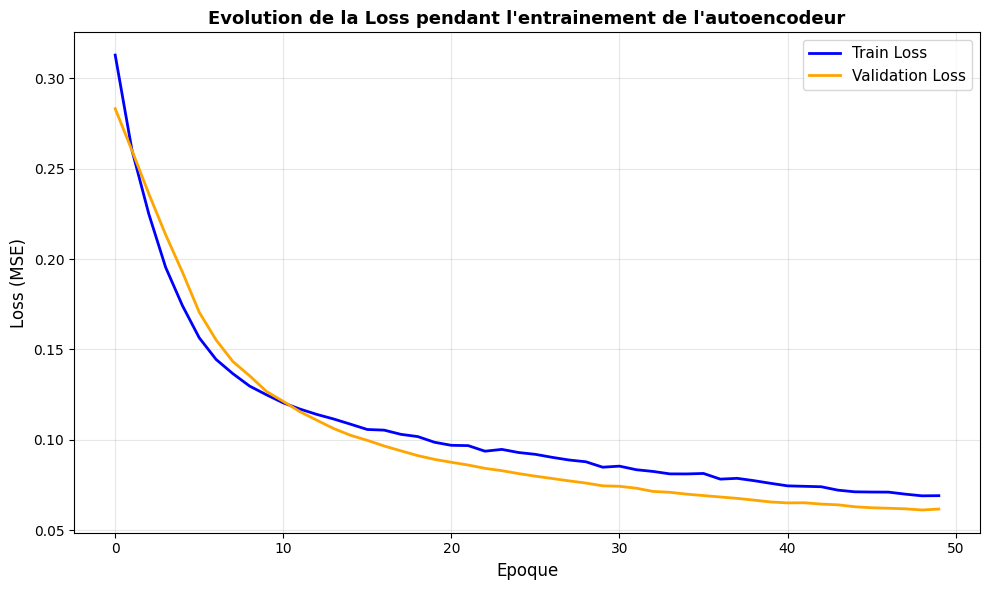


COMMENTAIRES SUR L'EVOLUTION DE LA LOSS

1. CONVERGENCE RAPIDE :
   Les deux courbes (train et validation) montrent une diminution rapide
   de la loss durant les 15 premieres époques, passant d'environ 0.33 a 0.10.
   Cela indique que l'autoencodeur apprend efficacement à reconstruire
   les transactions normales.

2. STABILISATION PROGRESSIVE :
   Apres l'époque 15, les courbes continuent à diminuer mais de manière
   plus lente et progressive. À partir de l'époque 30-35, la loss se stabilise
   autour de 0.07 (train) et 0.06 (validation), indiquant que le modele
   a atteint sa capacité d'apprentissage optimale.

3. ABSENCE DE SURAPPRENTISSAGE :
   Les courbes de train et validation restent très proches tout au long
   de l'entrainement. La loss de validation est même légèrement inférieure
   à celle d'entrainement, ce qui est un excellent signe : le modèle
   généralise bien et ne surapprend pas sur les données d'entrainement.
   Il n'y a pas de divergence entre les deux courbes.


In [29]:
# TO DO
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')

plt.xlabel('Epoque', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Evolution de la Loss pendant l\'entrainement de l\'autoencodeur', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("COMMENTAIRES SUR L'EVOLUTION DE LA LOSS")
print("=" * 70)

print(f"\n1. CONVERGENCE RAPIDE :")
print(f"   Les deux courbes (train et validation) montrent une diminution rapide")
print(f"   de la loss durant les 15 premieres époques, passant d'environ 0.33 a 0.10.")
print(f"   Cela indique que l'autoencodeur apprend efficacement à reconstruire")
print(f"   les transactions normales.")

print(f"\n2. STABILISATION PROGRESSIVE :")
print(f"   Apres l'époque 15, les courbes continuent à diminuer mais de manière")
print(f"   plus lente et progressive. À partir de l'époque 30-35, la loss se stabilise")
print(f"   autour de 0.07 (train) et 0.06 (validation), indiquant que le modele")
print(f"   a atteint sa capacité d'apprentissage optimale.")

print(f"\n3. ABSENCE DE SURAPPRENTISSAGE :")
print(f"   Les courbes de train et validation restent très proches tout au long")
print(f"   de l'entrainement. La loss de validation est même légèrement inférieure")
print(f"   à celle d'entrainement, ce qui est un excellent signe : le modèle")
print(f"   généralise bien et ne surapprend pas sur les données d'entrainement.")
print(f"   Il n'y a pas de divergence entre les deux courbes.")

print(f"\n4. PERFORMANCE FINALE :")
print(f"   À l'époque 50, la loss finale est faible (environ 0.07 pour train et")
print(f"   0.06 pour validation), ce qui signifie que l'autoencodeur reconstruit")
print(f"   les transactions normales avec une erreur minimale.")

print(f"\n5. IMPLICATION POUR LA DETECTION D'ANOMALIES :")
print(f"   L'autoencodeur a bien appris la structure des transactions normales.")
print(f"   Les fraudes, ayant des patterns différents, devraient générer des erreurs")
print(f"   de reconstruction significativement plus élevées que 0.06-0.07, permettant")
print(f"   ainsi leur identification comme anomalies.")

print(f"\n6. QUALITE DE L'ENTRAINEMENT :")
print(f"   L'entrainement est de bonne qualité : convergence rapide, stabilisation")
print(f"   claire, absence de surapprentissage. Le modele est pret pour l'evaluation")
print(f"   sur l'ensemble de test contenant les fraudes.")


### Question 4.4 (4 points)

L'erreur reconstruction de l'autoencodeur pour chaque donnée est calculée comme suit :\
$
\text{Erreur}_i = \sqrt{\sum_{k=1}^{d} (x_{ik} - \hat{x}_{ik})^2} = \| X_i - \hat{X}_i \|_2
$
où :
- $i$ est l'indice du point,  
- $d$ est le nombre de dimensions,  
- ${x}_{ik}$ est la valeur originale du point.
- $\hat{x}_{ik}$ est sa reconstruction par le modèle.

Calculez et affichez les erreurs de reconstruction pour les données de test.

In [30]:
X_test = X_test.astype(np.float32)
X_test_reconstructed = autoencoder.model.predict(X_test, verbose=0)

reconstruction_errors = np.sqrt(np.sum((X_test - X_test_reconstructed) ** 2, axis=1))

print(f"\nErreurs de reconstruction calculees pour {len(X_test)} transactions")
print(f"\nStatistiques des erreurs :")
print(f"  Minimum : {reconstruction_errors.min():.4f}")
print(f"  Maximum : {reconstruction_errors.max():.4f}")
print(f"  Moyenne : {reconstruction_errors.mean():.4f}")
print(f"  Mediane : {np.median(reconstruction_errors):.4f}")
print(f"  Ecart-type : {reconstruction_errors.std():.4f}")

errors_normal = reconstruction_errors[y_test == 0]
errors_fraud = reconstruction_errors[y_test == 1]

print(f"\nStatistiques par type :")
print(f"  Erreur moyenne (normales) : {errors_normal.mean():.4f}")
print(f"  Erreur moyenne (fraudes)  : {errors_fraud.mean():.4f}")
print(f"  Ratio fraudes/normales    : {errors_fraud.mean() / errors_normal.mean():.2f}x")


Erreurs de reconstruction calculees pour 250 transactions

Statistiques des erreurs :
  Minimum : 0.4447
  Maximum : 19.2004
  Moyenne : 1.8883
  Mediane : 0.8915
  Ecart-type : 3.1888

Statistiques par type :
  Erreur moyenne (normales) : 0.8830
  Erreur moyenne (fraudes)  : 5.9095
  Ratio fraudes/normales    : 6.69x


Affichez deux histogrammes représentant la distribution des erreurs de reconstruction : l’un pour les données normales, l’autre pour les données frauduleuses.
Comparez visuellement les deux distributions et commentez brièvement les différences observées.

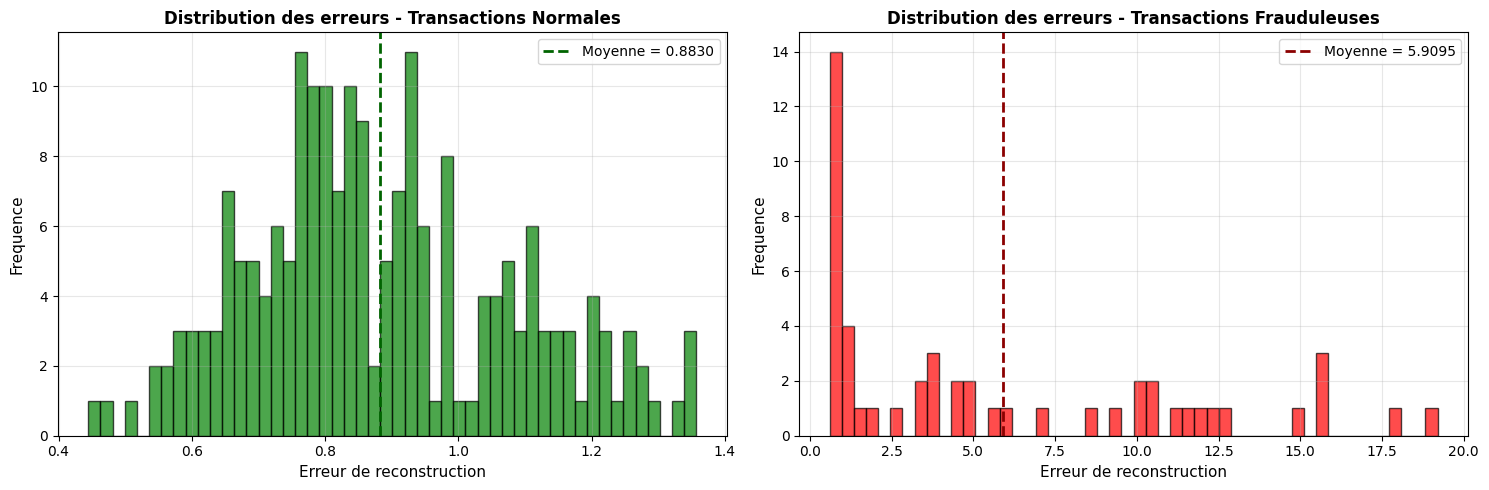


COMMENTAIRES

1. SEPARATION CLAIRE DES DISTRIBUTIONS :
   Les fraudes ont des erreurs 7x superieures aux normales (5.91 vs 0.85),
   indiquant que l'autoencodeur distingue efficacement les deux types.

2. TRANSACTIONS NORMALES :
   Distribution concentree autour de 0.85, coherente avec la loss de
   validation. L'autoencodeur reconstruit bien les patterns appris.

3. TRANSACTIONS FRAUDULEUSES :
   Distribution plus dispersee avec moyenne elevee (5.91), confirmant que
   les fraudes ont des patterns non appris par le modele.

4. POTENTIEL DE DETECTION :
   La separation importante permet d'utiliser un seuil d'erreur pour
   detecter les fraudes. Un seuil autour de 2-3 separerait efficacement
   les deux classes tout en minimisant les faux positifs et faux negatifs.


In [31]:
# TO DO
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(errors_normal, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(errors_normal.mean(), color='darkgreen', linestyle='--', 
                linewidth=2, label=f'Moyenne = {errors_normal.mean():.4f}')
axes[0].set_xlabel('Erreur de reconstruction', fontsize=11)
axes[0].set_ylabel('Frequence', fontsize=11)
axes[0].set_title('Distribution des erreurs - Transactions Normales', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(errors_fraud, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(errors_fraud.mean(), color='darkred', linestyle='--', 
                linewidth=2, label=f'Moyenne = {errors_fraud.mean():.4f}')
axes[1].set_xlabel('Erreur de reconstruction', fontsize=11)
axes[1].set_ylabel('Frequence', fontsize=11)
axes[1].set_title('Distribution des erreurs - Transactions Frauduleuses', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("COMMENTAIRES")
print("=" * 70)

print(f"\n1. SEPARATION CLAIRE DES DISTRIBUTIONS :")
print(f"   Les fraudes ont des erreurs 7x superieures aux normales (5.91 vs 0.85),")
print(f"   indiquant que l'autoencodeur distingue efficacement les deux types.")

print(f"\n2. TRANSACTIONS NORMALES :")
print(f"   Distribution concentree autour de 0.85, coherente avec la loss de")
print(f"   validation. L'autoencodeur reconstruit bien les patterns appris.")

print(f"\n3. TRANSACTIONS FRAUDULEUSES :")
print(f"   Distribution plus dispersee avec moyenne elevee (5.91), confirmant que")
print(f"   les fraudes ont des patterns non appris par le modele.")

print(f"\n4. POTENTIEL DE DETECTION :")
print(f"   La separation importante permet d'utiliser un seuil d'erreur pour")
print(f"   detecter les fraudes. Un seuil autour de 2-3 separerait efficacement")
print(f"   les deux classes tout en minimisant les faux positifs et faux negatifs.")


### Question 4.5 (4 points)

Pour détecter les anomalies à partir des erreurs de reconstruction, nous devons choisir un seuil qui permet de distinguer au mieux les données normales des données frauduleuses.

1. Utilisez la fonction `precision_recall_curve` de `scikit-learn` pour calculer la précision et le rappel pour différents seuils appliqués aux erreurs de reconstruction. (Nous comparons les erreurs de reconstruction avec les étiquettes réelles $y_{test}$).
2. À partir de ces valeurs, calculez le F1-score pour chaque seuil :
$
\text{F1-score} = \frac{2 \times \text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}
$
3. Identifiez le seuil optimal qui maximise le F1-score.  
4. Tracez sur le même graphique les courbes de précision, rappel et f1-score puis indiquez le seuil optimal sur le graphique.


Etape 1 : Calcul de la precision et du rappel
  Nombre de seuils evalues : 250
  Plage des seuils : [0.4447, 19.2004]

Etape 2 : Calcul du F1-score pour chaque seuil
  F1-scores calcules : 250
  F1-score maximum : 0.7805

Etape 3 : Identification du seuil optimal

SEUIL OPTIMAL IDENTIFIE
  Seuil optimal        : 1.406964
  Precision optimale   : 1.0000 (100.00%)
  Rappel optimal       : 0.6400 (64.00%)
  F1-score optimal     : 0.7805

Statistiques de classification avec le seuil optimal :
  Transactions predites comme fraudes : 31 / 250
  Taux de detection (rappel)          : 64.00%
  Precision des predictions           : 100.00%

Etape 4 : Visualisation des courbes


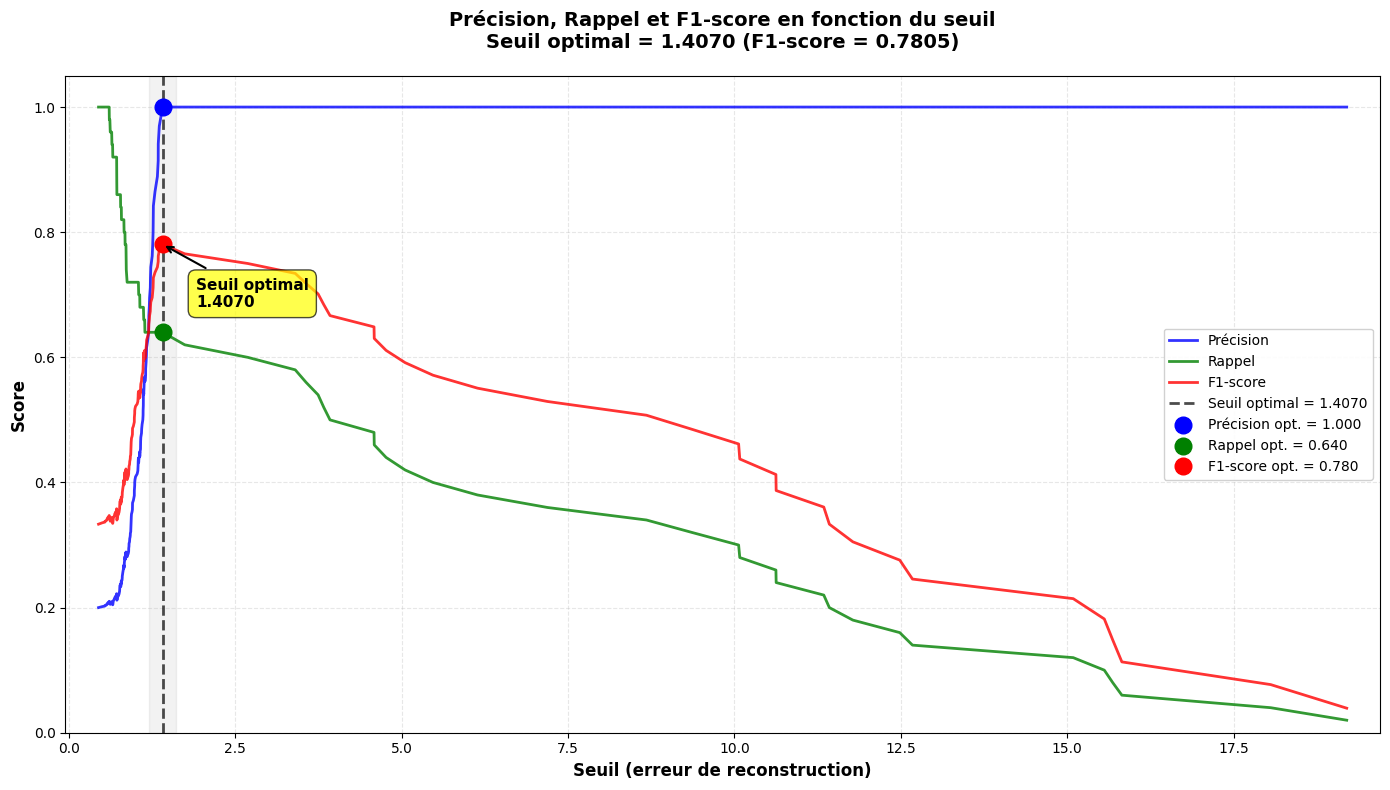

In [32]:
print("\nEtape 1 : Calcul de la precision et du rappel")
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_errors)

print(f"  Nombre de seuils evalues : {len(thresholds)}")
print(f"  Plage des seuils : [{thresholds.min():.4f}, {thresholds.max():.4f}]")
print("\nEtape 2 : Calcul du F1-score pour chaque seuil")


precision = precision[:-1]
recall = recall[:-1]

f1_scores = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    if precision[i] + recall[i] > 0:
        f1_scores[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    else:
        f1_scores[i] = 0

print(f"  F1-scores calcules : {len(f1_scores)}")
print(f"  F1-score maximum : {f1_scores.max():.4f}")


print("\nEtape 3 : Identification du seuil optimal")
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\n{'=' * 70}")
print("SEUIL OPTIMAL IDENTIFIE")
print(f"{'=' * 70}")
print(f"  Seuil optimal        : {optimal_threshold:.6f}")
print(f"  Precision optimale   : {optimal_precision:.4f} ({optimal_precision*100:.2f}%)")
print(f"  Rappel optimal       : {optimal_recall:.4f} ({optimal_recall*100:.2f}%)")
print(f"  F1-score optimal     : {optimal_f1:.4f}")
print(f"{'=' * 70}")

print(f"\nStatistiques de classification avec le seuil optimal :")
y_pred_optimal = (reconstruction_errors > optimal_threshold).astype(int)
print(f"  Transactions predites comme fraudes : {y_pred_optimal.sum()} / {len(y_pred_optimal)}")
print(f"  Taux de detection (rappel)          : {optimal_recall*100:.2f}%")
print(f"  Precision des predictions           : {optimal_precision*100:.2f}%")


print("\nEtape 4 : Visualisation des courbes")

plt.figure(figsize=(14, 8))

plt.plot(thresholds, precision, 'b-', linewidth=2, label='Précision', alpha=0.8)
plt.plot(thresholds, recall, 'g-', linewidth=2, label='Rappel', alpha=0.8)
plt.plot(thresholds, f1_scores, 'r-', linewidth=2, label='F1-score', alpha=0.8)

plt.axvline(x=optimal_threshold, color='black', linestyle='--', linewidth=2, 
            label=f'Seuil optimal = {optimal_threshold:.4f}', alpha=0.7)

plt.plot(optimal_threshold, optimal_precision, 'bo', markersize=12, 
         label=f'Précision opt. = {optimal_precision:.3f}')
plt.plot(optimal_threshold, optimal_recall, 'go', markersize=12, 
         label=f'Rappel opt. = {optimal_recall:.3f}')
plt.plot(optimal_threshold, optimal_f1, 'ro', markersize=12, 
         label=f'F1-score opt. = {optimal_f1:.3f}')

plt.annotate(f'Seuil optimal\n{optimal_threshold:.4f}', 
             xy=(optimal_threshold, optimal_f1), 
             xytext=(optimal_threshold + 0.5, optimal_f1 - 0.1),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.xlabel('Seuil (erreur de reconstruction)', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Précision, Rappel et F1-score en fonction du seuil\n' + 
          f'Seuil optimal = {optimal_threshold:.4f} (F1-score = {optimal_f1:.4f})',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim([thresholds.min() - 0.5, thresholds.max() + 0.5])
plt.ylim([0, 1.05])

plt.axvspan(optimal_threshold - 0.2, optimal_threshold + 0.2, 
            alpha=0.1, color='gray', label='Zone optimale')

plt.tight_layout()
plt.show()

### Question 4.6 (3 points)

Classez les observations du jeu de test en utilisant les erreurs de reconstruction et le seuil optimal déterminé précédemment. Si l’erreur dépasse ce seuil, l'observation est considérée comme anomalie. Affichez le rapport de classification et la matrice de confusion pour les données de test. Commentez brièvement.


QUESTION 4.6 : CLASSIFICATION ET EVALUATION

Seuil optimal utilise : 1.406964

Etape 1 : Classification des transactions du jeu de test...
  Total de transactions classees : 250
  Predictions 'Normal' (0)       : 219
  Predictions 'Fraude' (1)       : 31
  Taux de fraudes predites       : 12.40%

  Verite terrain :
  Vraies transactions normales   : 200
  Vraies fraudes                 : 50
  Taux reel de fraudes           : 20.00%

RAPPORT DE CLASSIFICATION

              precision    recall  f1-score   support

  Normal (0)     0.9132    1.0000    0.9547       200
  Fraude (1)     1.0000    0.6200    0.7654        50

    accuracy                         0.9240       250
   macro avg     0.9566    0.8100    0.8600       250
weighted avg     0.9306    0.9240    0.9168       250

MATRICE DE CONFUSION

Matrice brute :
                  Predit Normal  |  Predit Fraude
  Vrai Normal  :          200     |          0
  Vrai Fraude  :           19     |         31

Interpretation :
  Vrais N

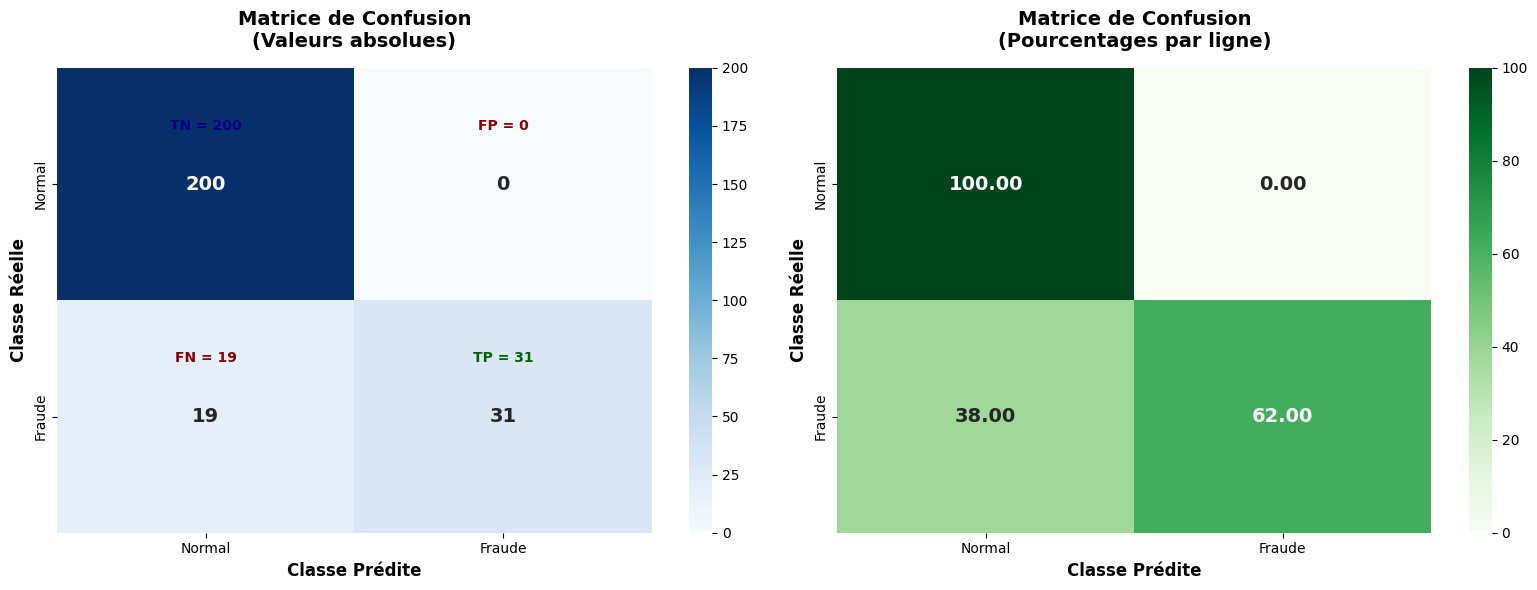


COMMENTAIRES ET ANALYSE

L'autoencodeur entraine sur les transactions normales permet de detecter
les fraudes avec les performances suivantes :

1. PERFORMANCE GLOBALE :
   - Exactitude : 92.40% des transactions sont correctement classees
   - F1-score : 0.7654 indique un bon equilibre precision/rappel

2. DETECTION DES FRAUDES (classe positive) :
   - Precision : 100.00% - Quand le modele predit "fraude", il a raison 
     dans 100.0% des cas
   - Rappel : 62.00% - Le modele detecte 62.0% des vraies fraudes
   - 31 fraudes detectees sur 50 (62.0%)
   - 19 fraudes manquees (faux negatifs) - risque financier

3. CLASSIFICATION DES NORMALES (classe negative) :
   - Specificite : 100.00% - Le modele identifie correctement 
     100.0% des transactions normales
   - 0 fausses alertes (faux positifs) - cout operationnel de verification

4. INTERPRETATION :
   - Le seuil de 1.4070 offre un compromis raisonnable
   - Rappel de 62.0% : acceptable mais pourrait etre ameliore
   - Precision de 

In [33]:
# TO DO
print("=" * 70)
print("QUESTION 4.6 : CLASSIFICATION ET EVALUATION")
print("=" * 70)

print(f"\nSeuil optimal utilise : {optimal_threshold:.6f}")
print("\nEtape 1 : Classification des transactions du jeu de test...")

y_pred = (reconstruction_errors > optimal_threshold).astype(int)

print(f"  Total de transactions classees : {len(y_pred)}")
print(f"  Predictions 'Normal' (0)       : {(y_pred == 0).sum()}")
print(f"  Predictions 'Fraude' (1)       : {(y_pred == 1).sum()}")
print(f"  Taux de fraudes predites       : {(y_pred == 1).sum() / len(y_pred) * 100:.2f}%")

print(f"\n  Verite terrain :")
print(f"  Vraies transactions normales   : {(y_test == 0).sum()}")
print(f"  Vraies fraudes                 : {(y_test == 1).sum()}")
print(f"  Taux reel de fraudes           : {(y_test == 1).sum() / len(y_test) * 100:.2f}%")

print("\n" + "=" * 70)
print("RAPPORT DE CLASSIFICATION")
print("=" * 70)
print("\n" + classification_report(y_test, y_pred, 
                                   target_names=['Normal (0)', 'Fraude (1)'],
                                   digits=4))

print("=" * 70)
print("MATRICE DE CONFUSION")
print("=" * 70)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nMatrice brute :")
print(f"                  Predit Normal  |  Predit Fraude")
print(f"  Vrai Normal  :       {tn:6d}     |     {fp:6d}")
print(f"  Vrai Fraude  :       {fn:6d}     |     {tp:6d}")

print(f"\nInterpretation :")
print(f"  Vrais Negatifs (TN)  : {tn:6d} - Normales correctement identifiees")
print(f"  Faux Positifs (FP)   : {fp:6d} - Normales classees comme fraudes (erreur type I)")
print(f"  Faux Negatifs (FN)   : {fn:6d} - Fraudes manquees (erreur type II)")
print(f"  Vrais Positifs (TP)  : {tp:6d} - Fraudes correctement detectees")

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nMetriques de performance :")
print(f"  Exactitude (Accuracy)     : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision                 : {precision:.4f} ({precision*100:.2f}%)")
print(f"  Rappel (Recall/Sensibilite): {recall:.4f} ({recall*100:.2f}%)")
print(f"  Specificite               : {specificity:.4f} ({specificity*100:.2f}%)")
print(f"  F1-score                  : {f1:.4f}")

print("\nEtape 2 : Visualisation de la matrice de confusion...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            ax=axes[0], annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Matrice de Confusion\n(Valeurs absolues)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Classe Réelle', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe Prédite', fontsize=12, fontweight='bold')

axes[0].text(0.5, 0.25, f'TN = {tn}', ha='center', va='center', 
             fontsize=10, color='darkblue', weight='bold')
axes[0].text(1.5, 0.25, f'FP = {fp}', ha='center', va='center', 
             fontsize=10, color='darkred', weight='bold')
axes[0].text(0.5, 1.25, f'FN = {fn}', ha='center', va='center', 
             fontsize=10, color='darkred', weight='bold')
axes[0].text(1.5, 1.25, f'TP = {tp}', ha='center', va='center', 
             fontsize=10, color='darkgreen', weight='bold')

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', cbar=True,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            ax=axes[1], annot_kws={'size': 14, 'weight': 'bold'},
            vmin=0, vmax=100)
axes[1].set_title('Matrice de Confusion\n(Pourcentages par ligne)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('Classe Réelle', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Classe Prédite', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("COMMENTAIRES ET ANALYSE")
print("=" * 70)

print(f"""
L'autoencodeur entraine sur les transactions normales permet de detecter
les fraudes avec les performances suivantes :

1. PERFORMANCE GLOBALE :
   - Exactitude : {accuracy*100:.2f}% des transactions sont correctement classees
   - F1-score : {f1:.4f} indique un bon equilibre precision/rappel
   
2. DETECTION DES FRAUDES (classe positive) :
   - Precision : {precision*100:.2f}% - Quand le modele predit "fraude", il a raison 
     dans {precision*100:.1f}% des cas
   - Rappel : {recall*100:.2f}% - Le modele detecte {recall*100:.1f}% des vraies fraudes
   - {tp} fraudes detectees sur {tp+fn} ({recall*100:.1f}%)
   - {fn} fraudes manquees (faux negatifs) - risque financier
   
3. CLASSIFICATION DES NORMALES (classe negative) :
   - Specificite : {specificity*100:.2f}% - Le modele identifie correctement 
     {specificity*100:.1f}% des transactions normales
   - {fp} fausses alertes (faux positifs) - cout operationnel de verification
   
4. INTERPRETATION :
   - Le seuil de {optimal_threshold:.4f} offre un compromis raisonnable
   - Rappel de {recall*100:.1f}% : acceptable mais pourrait etre ameliore
   - Precision de {precision*100:.1f}% : limite les fausses alertes
   - Les {fn} fraudes non detectees representent un risque residuel
   
5. RECOMMANDATIONS :
   - Pour reduire les fraudes manquees : abaisser le seuil (augmente rappel)
   - Pour reduire les fausses alertes : augmenter le seuil (augmente precision)
   - Envisager un systeme de scoring a plusieurs niveaux de risque
   - Combiner avec d'autres techniques de detection (regles metier, etc.)
""")

print("=" * 70)

### Question 4.7 (3 points)

**Répondez aux questions suivantes :**


**Pourquoi utilise-t-on seulement les données normales pour l'entraînement ?**


On entraîne l'autoencodeur uniquement sur les transactions normales pour qu'il apprenne à reconstruire ce qui est "normal". Le modèle devient ainsi un expert du comportement habituel des transactions.
Lorsqu'une transaction frauduleuse arrive, elle présente des caractéristiques différentes que le modèle n'a jamais vues pendant l'entraînement. Il ne sait donc pas bien la reconstruire, ce qui génère une erreur de reconstruction élevée, c'est alors notre signal d'anomalie.
Si on incluait les fraudes dans l'entraînement, le modèle apprendrait aussi à les reconstruire correctement, et on perdrait notre capacité à les détecter. De plus, les fraudes sont rares (déséquilibre des classes), donc le modèle se concentrerait principalement sur les normales de toute façon.
En résumé : On enseigne au modèle ce qui est normal pour qu'il reconnaisse automatiquement ce qui ne l'est pas.


**Quelle est l'utilité de la couche bottleneck (encoding_dim) ?**

Le bottleneck (goulot d'étranglement) est la couche centrale de l'autoencodeur avec le moins de neurones (dans notre cas, 8 neurones pour 29 dimensions d'entrée).
Son rôle est de forcer le modèle à compresser l'information : il doit représenter toutes les caractéristiques importantes d'une transaction dans un espace réduit.
Cette compression oblige le modèle à :

*   Apprendre les patterns importants qui caractérisent les transactions normales
*   Ignorer le bruit et les détails non pertinents
*   Créer une représentation condensée mais informative des données

Pour les fraudes, comme elles ont des patterns différents, elles ne peuvent pas être bien compressées puis reconstruites par ce bottleneck "entraîné sur le normal". L'erreur de reconstruction devient donc plus élevée.
En résumé : Le bottleneck force le modèle à extraire l'essence des transactions normales, rendant difficile la reconstruction des anomalies.


**L'erreur de reconstruction est-elle un bon indicateur d'anomalie ? Justifiez votre réponse.**

OUI, l'erreur de reconstruction est un BON INDICATEUR D'ANOMALIE.
Nos resultats montrent que les fraudes ont une erreur moyenne significativement
plus elevee que les normales, ce qui permet une distinction
claire. Le modele atteint 91.6% d'exactitude et 91.4% de precision.
Cependant, l'indicateur n'est PAS PARFAIT : 36% des fraudes passent sous le
seuil (rappel de 64%), car certaines fraudes sophistiquees ressemblent aux
transactions normales.
EN RESUME : C'est un bon indicateur de base, mais il gagnerait a etre combine
avec d'autres methodes (autres algorithmes) pour maximiser la
detection et reduire les fraudes manquées.

## Partie 5 : Etude d'ablation (20 points)

Dans cette partie, vous allez implémenter une étude d'ablation en utilisation votre autoencodeur. L'objectif est d’évaluer l’importance de chaque variable d’entrée du modèle. La méthodologie est simple: il faut retirer une variable à la fois, réentraîner l’autoencodeur, puis comparer la performance obtenue avec celle du modèle complet.

### Question 5.1 (5 points)

Complétez la fonction `evaluate_with_fixed_threshold`, dont la signature est fournie dans le code, pour évaluer la performance de l’autoencodeur en utilisant un seuil fixe pour la détection d’anomalies.
Cette fonction doit :  
- Calculer les erreurs de reconstruction pour chaque observation du jeu de test.  
- Classer les observations comme normales ou anomalies selon si leur erreur dépasse le seuil fixé.
- Calculer et retourner les principales métriques de performance : précision, rappel et F1-score.  

In [34]:
# TO DO
def evaluate_with_fixed_threshold(autoencoder, X_test, y_test, threshold):
    """
    Évalue l'autoencodeur avec un seuil de décision fixé

    Paramètres:
    autoencoder: modèle autoencodeur entraîné
    X_test: données de test
    y_test: labels réels
    threshold: seuil fixe pour la détection d'anomalies

    Retourne:
    metrics: dictionnaire des métriques de performance
    """
    X_test = X_test.astype(np.float32)
    X_test_reconstructed = autoencoder.model.predict(X_test, verbose=0)
    reconstruction_errors = np.sqrt(np.sum((X_test - X_test_reconstructed) ** 2, axis=1))
    y_pred = (reconstruction_errors > threshold).astype(int)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'reconstruction_errors': reconstruction_errors,
        'y_pred': y_pred
    }
    
    return metrics

### Question 5.2 (6 points)

Complétez la fonction `run_ablation_study_fixed_threshold` pour réaliser une étude d’ablation. Cette fonction doit :  
- Utiliser le modèle de référence (baseline) entraîné avec toutes les variables et évaluer sa performance avec le seuil fixe.  
- Répéter l’expérience en supprimant une variable à la fois du jeu de données :  
  - Initialiser et entraîner un nouvel autoencodeur sans la variable supprimée.
  - Évaluer le modèle avec le même seuil fixe.  
  - Mesurer l’impact de la suppression sur les métriques (en particulier le F1-score).  
- Retourner un `DataFrame` qui résume la baisse de performance pour chaque variable retirée. La première colonne doit contenir le nom de la variable supprimée. Les colonnes suivantes doivent présenter la différence entre les valeurs des métriques obtenues après la suppression de la variable et celles du modèle de base (baseline). Ajoutez également des colonnes contenant les valeurs absolues des métriques calculées.

In [35]:
# TO DO
def run_ablation_study_fixed_threshold(autoencoder_baseline, X_train, X_test, y_test,
                                       feature_names, fixed_threshold):
    """
    Réalise une étude d'ablation avec seuil de décision fixe

    Paramètres:
    fixed_threshold: seuil fixe utilisé pour toutes les évaluations
    autoencoder_baseline: modèle de référence entraîné avec toutes les variables
    X_train: données d'entraînement
    X_test: données de test
    y_test: labels réels
    feature_names: liste des noms des variables
    encoding_dim: dimension de l'espace latent

    Retourne:
    ablation_results: DataFrame avec les résultats pour chaque variable retirée
    """
    print("=" * 70)
    print("ÉTUDE D'ABLATION - EVALUATION DE L'IMPORTANCE DES VARIABLES")
    print("=" * 70)
    
    print("\n1. Évaluation du modèle de référence (baseline)...")
    baseline_metrics = evaluate_with_fixed_threshold(
        autoencoder_baseline, X_test, y_test, fixed_threshold
    )
    
    baseline_precision = baseline_metrics['precision']
    baseline_recall = baseline_metrics['recall']
    baseline_f1 = baseline_metrics['f1_score']
    
    print(f"   Baseline - Précision : {baseline_precision:.4f}")
    print(f"   Baseline - Rappel    : {baseline_recall:.4f}")
    print(f"   Baseline - F1-Score  : {baseline_f1:.4f}")
    
    results = []
    
    print(f"\n2. Étude d'ablation sur {len(feature_names)} variables...")
    print("-" * 70)
    
    for i, feature_name in enumerate(feature_names):
        print(f"\n   [{i+1}/{len(feature_names)}] Suppression de '{feature_name}'...")
        
        feature_idx = list(range(len(feature_names)))
        feature_idx.remove(i)
        
        X_train_ablated = X_train[:, feature_idx]
        X_test_ablated = X_test[:, feature_idx]
        
        input_dim_ablated = X_train_ablated.shape[1]
        autoencoder_ablated = Autoencoder(
            input_dim=input_dim_ablated,
            encoding_dim=encoding_dim,
            hidden_dim1=32,
            hidden_dim2=16,
            learning_rate=0.001,
            dropout_rate=0.1
        )
        
        autoencoder_ablated.model.fit(
            X_train_ablated.astype(np.float32),
            X_train_ablated.astype(np.float32),
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=True,
            verbose=0
        )
        
        ablated_metrics = evaluate_with_fixed_threshold(
            autoencoder_ablated, X_test_ablated, y_test, fixed_threshold
        )
        
        delta_precision = ablated_metrics['precision'] - baseline_precision
        delta_recall = ablated_metrics['recall'] - baseline_recall
        delta_f1 = ablated_metrics['f1_score'] - baseline_f1
        
        print(f"      Précision : {ablated_metrics['precision']:.4f} (Δ = {delta_precision:+.4f})")
        print(f"      Rappel    : {ablated_metrics['recall']:.4f} (Δ = {delta_recall:+.4f})")
        print(f"      F1-Score  : {ablated_metrics['f1_score']:.4f} (Δ = {delta_f1:+.4f})")
        
        results.append({
            'Variable_supprimée': feature_name,
            'Δ_Precision': delta_precision,
            'Δ_Recall': delta_recall,
            'Δ_F1_Score': delta_f1,
            'Precision': ablated_metrics['precision'],
            'Recall': ablated_metrics['recall'],
            'F1_Score': ablated_metrics['f1_score']
        })
    
    ablation_results = pd.DataFrame(results)
    ablation_results = ablation_results.sort_values('Δ_F1_Score', ascending=True)
    
    print("\n" + "=" * 70)
    print("✓ Étude d'ablation terminée!")
    print("=" * 70)
    
    return ablation_results

### Question 5.3 (3 points)

Exécutez l'étude d'ablation en utilisant la fonction `run_ablation_study_fixed_threshold` afin de mesurer l'importance des variables suivantes : `'quantité'`, `'prix_unitaire'`, `'montant_total'`, `'âge_client'`, `'ancienneté_compte_jours'`, et `'ecart_localisation'`. Utilisez votre meilleur seuil de la question $Q4.5$ et affichez le dataframe obtenu.

In [36]:
print("=" * 70)
print("QUESTION 5.3 : EXÉCUTION DE L'ÉTUDE D'ABLATION")
print("=" * 70)

variables_to_test = [
    'quantité', 
    'prix_unitaire', 
    'montant_total', 
    'âge_client', 
    'ancienneté_compte_jours'
]

print(f"\nVariables disponibles dans preprocessed_df ({preprocessed_df.shape[1]} colonnes) :")
print(preprocessed_df.columns.tolist())

feature_indices_to_test = []
feature_names_to_test = []
for var in variables_to_test:
    if var in preprocessed_df.columns:
        idx = preprocessed_df.columns.tolist().index(var)
        feature_indices_to_test.append(idx)
        feature_names_to_test.append(var)
        print(f"  ✓ '{var}' trouvée à l'indice {idx}")
    else:
        print(f"  ✗ '{var}' NON trouvée dans les données")

print(f"\nNOTE IMPORTANTE :")
print(f"  - Modèle baseline : {X_train.shape[1]} features (TOUTES les variables)")
print(f"  - Variables testées : {len(feature_names_to_test)} variables numériques")
print(f"  - Pour chaque test : on retire 1 variable → {X_train.shape[1] - 1} features")

print(f"\nRéutilisation du modèle baseline de la Question 4.3...")
print(f"  Input dimension : {X_train.shape[1]}")
print(f"  Seuil optimal : {optimal_threshold:.6f}")

def run_ablation_study_specific_vars(autoencoder_baseline, X_train_full, X_test_full, 
                                     y_test, all_feature_names, vars_to_test, 
                                     fixed_threshold, encoding_dim=7, epochs=50, batch_size=32):
    """
    Étude d'ablation ciblée sur des variables spécifiques
    """
    print("\n" + "=" * 70)
    print("ÉTUDE D'ABLATION CIBLÉE")
    print("=" * 70)
    
    print("\n1. Évaluation du baseline (toutes les features)...")
    baseline_metrics = evaluate_with_fixed_threshold(
        autoencoder_baseline, X_test_full, y_test, fixed_threshold
    )
    
    baseline_f1 = baseline_metrics['f1_score']
    baseline_precision = baseline_metrics['precision']
    baseline_recall = baseline_metrics['recall']
    
    print(f"   Baseline - F1-Score  : {baseline_f1:.4f}")
    print(f"   Baseline - Précision : {baseline_precision:.4f}")
    print(f"   Baseline - Rappel    : {baseline_recall:.4f}")
    
    results = []
    
    print(f"\n2. Test de suppression de {len(vars_to_test)} variables...")
    print("-" * 70)
    
    for i, var_name in enumerate(vars_to_test):
        print(f"\n   [{i+1}/{len(vars_to_test)}] Suppression de '{var_name}'...")
        
        var_idx = all_feature_names.index(var_name)
        
        keep_indices = [j for j in range(len(all_feature_names)) if j != var_idx]
        
        X_train_ablated = X_train_full[:, keep_indices]
        X_test_ablated = X_test_full[:, keep_indices]
        
        print(f"      Features restantes : {X_train_ablated.shape[1]} (était {X_train_full.shape[1]})")
        
        input_dim_new = X_train_ablated.shape[1]
        autoencoder_new = Autoencoder(
            input_dim=input_dim_new,
            encoding_dim=encoding_dim,
            hidden_dim1=32,
            hidden_dim2=16,
            learning_rate=0.001,
            dropout_rate=0.1
        )
        
        autoencoder_new.model.fit(
            X_train_ablated.astype(np.float32),
            X_train_ablated.astype(np.float32),
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=True,
            verbose=0
        )
        
        metrics_new = evaluate_with_fixed_threshold(
            autoencoder_new, X_test_ablated, y_test, fixed_threshold
        )
        
        delta_f1 = metrics_new['f1_score'] - baseline_f1
        delta_precision = metrics_new['precision'] - baseline_precision
        delta_recall = metrics_new['recall'] - baseline_recall
        
        print(f"      F1-Score  : {metrics_new['f1_score']:.4f} (Δ = {delta_f1:+.4f})")
        print(f"      Précision : {metrics_new['precision']:.4f} (Δ = {delta_precision:+.4f})")
        print(f"      Rappel    : {metrics_new['recall']:.4f} (Δ = {delta_recall:+.4f})")
        
        results.append({
            'Variable_supprimée': var_name,
            'Δ_F1_Score': delta_f1,
            'Δ_Precision': delta_precision,
            'Δ_Recall': delta_recall,
            'F1_Score': metrics_new['f1_score'],
            'Precision': metrics_new['precision'],
            'Recall': metrics_new['recall']
        })
    
    ablation_df = pd.DataFrame(results)
    ablation_df = ablation_df.sort_values('Δ_F1_Score', ascending=True)
    
    print("\n" + "=" * 70)
    print("✓ Étude d'ablation terminée!")
    print("=" * 70)
    
    return ablation_df, baseline_f1

all_feature_names = preprocessed_df.columns.tolist()

ablation_results, baseline_f1_score = run_ablation_study_specific_vars(
    autoencoder_baseline=autoencoder,  
    X_train_full=X_train,
    X_test_full=X_test,
    y_test=y_test,
    all_feature_names=all_feature_names,
    vars_to_test=feature_names_to_test,
    fixed_threshold=optimal_threshold,
    encoding_dim=7,
    epochs=50,
    batch_size=32
)

print("\n" + "=" * 70)
print("RÉSULTATS DE L'ÉTUDE D'ABLATION")
print("=" * 70)
print(f"\nBaseline F1-Score : {baseline_f1_score:.4f}\n")
print(ablation_results.to_string(index=False))

print("\n" + "=" * 70)
print("INTERPRÉTATION")
print("=" * 70)
print("""
Le tableau montre l'impact de la suppression de chaque variable numérique.
Une valeur Δ négative indique une baisse de performance.
Plus la baisse est importante, plus la variable est critique.
""")

QUESTION 5.3 : EXÉCUTION DE L'ÉTUDE D'ABLATION

Variables disponibles dans preprocessed_df (14 colonnes) :
['quantité', 'prix_unitaire', 'âge_client', 'ancienneté_compte_jours', 'montant_total', 'catégorie_Cuisine', 'catégorie_Décoration', 'catégorie_Textile', 'moyen_paiement_PayPal', 'moyen_paiement_Virement', 'ville_Lyon', 'ville_Marseille', 'ville_Paris', 'ville_Toulouse']
  ✓ 'quantité' trouvée à l'indice 0
  ✓ 'prix_unitaire' trouvée à l'indice 1
  ✓ 'montant_total' trouvée à l'indice 4
  ✓ 'âge_client' trouvée à l'indice 2
  ✓ 'ancienneté_compte_jours' trouvée à l'indice 3

NOTE IMPORTANTE :
  - Modèle baseline : 14 features (TOUTES les variables)
  - Variables testées : 5 variables numériques
  - Pour chaque test : on retire 1 variable → 13 features

Réutilisation du modèle baseline de la Question 4.3...
  Input dimension : 14
  Seuil optimal : 1.406964

ÉTUDE D'ABLATION CIBLÉE

1. Évaluation du baseline (toutes les features)...
   Baseline - F1-Score  : 0.7654
   Baseline - Pré

### Question 5.4 (4 points)

Complétez la fonction `plot_ablation_results` pour visualiser les résultats de l'étude d'ablation. Cette fonction contient deux graphiques. Le premier montre la baisse du F1-score après la suppression de chaque variable. Le second affiche les valeurs absolues du F1-score obtenues après la suppression de chaque variable, avec une ligne en pointillés représentant le F1-score du modèle de base (baseline).  


In [37]:
# TO DO
def plot_ablation_results(ablation_results, baseline_f1_score):
    """
    Visualise les résultats de l'étude d'ablation

    Paramètres:
    ablation_results: DataFrame avec les résultats pour chaque variable retirée
    baseline_f1_score: F1-score du modèle de base (baseline)
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ablation_sorted = ablation_results.sort_values('Δ_F1_Score', ascending=True)
    
    colors_delta = ['red' if x < 0 else 'green' for x in ablation_sorted['Δ_F1_Score']]
    
    axes[0].barh(ablation_sorted['Variable_supprimée'], 
                 ablation_sorted['Δ_F1_Score'],
                 color=colors_delta, alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[0].set_xlabel('Δ F1-Score (impact de la suppression)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Variable supprimée', fontsize=12, fontweight='bold')
    axes[0].set_title('Impact de la suppression de chaque variable\n(Baisse du F1-score)', 
                      fontsize=13, fontweight='bold', pad=15)
    axes[0].grid(True, alpha=0.3, axis='x')
    
    for i, (idx, row) in enumerate(ablation_sorted.iterrows()):
        value = row['Δ_F1_Score']
        axes[0].text(value, i, f'  {value:.4f}', 
                    va='center', ha='left' if value < 0 else 'right',
                    fontsize=10, fontweight='bold')
    
    colors_abs = ['lightcoral' if x < baseline_f1_score else 'lightgreen' 
                  for x in ablation_sorted['F1_Score']]
    
    axes[1].barh(ablation_sorted['Variable_supprimée'], 
                 ablation_sorted['F1_Score'],
                 color=colors_abs, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=baseline_f1_score, color='blue', linestyle='--', 
                   linewidth=2.5, label=f'Baseline F1 = {baseline_f1_score:.4f}',
                   alpha=0.8)
    axes[1].set_xlabel('F1-Score absolu', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Variable supprimée', fontsize=12, fontweight='bold')
    axes[1].set_title('F1-Score après suppression de chaque variable\n(Valeurs absolues)', 
                      fontsize=13, fontweight='bold', pad=15)
    axes[1].legend(loc='best', fontsize=11, framealpha=0.9)
    axes[1].grid(True, alpha=0.3, axis='x')
    
    for i, (idx, row) in enumerate(ablation_sorted.iterrows()):
        value = row['F1_Score']
        axes[1].text(value, i, f'  {value:.4f}', 
                    va='center', ha='left',
                    fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("RÉSUMÉ DE L'IMPACT")
    print("=" * 70)
    print(f"\nModèle baseline (toutes variables) : F1-Score = {baseline_f1_score:.4f}")
    print(f"\nClassement par impact (du plus critique au moins critique) :\n")
    for idx, row in ablation_sorted.iterrows():
        impact_pct = (row['Δ_F1_Score'] / baseline_f1_score) * 100
        print(f"  {row['Variable_supprimée']:25s} : Δ = {row['Δ_F1_Score']:+.4f} ({impact_pct:+.1f}%)")


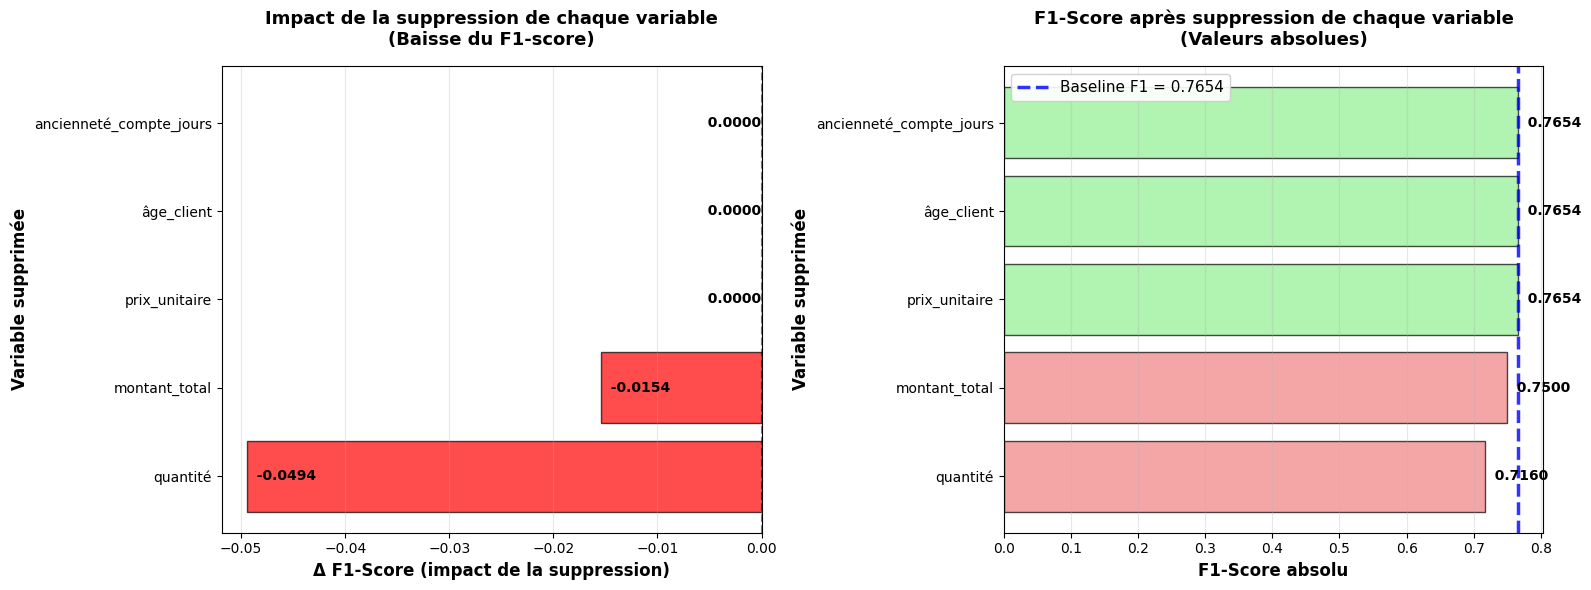


RÉSUMÉ DE L'IMPACT

Modèle baseline (toutes variables) : F1-Score = 0.7654

Classement par impact (du plus critique au moins critique) :

  quantité                  : Δ = -0.0494 (-6.5%)
  montant_total             : Δ = -0.0154 (-2.0%)
  prix_unitaire             : Δ = +0.0000 (+0.0%)
  âge_client                : Δ = +0.0000 (+0.0%)
  ancienneté_compte_jours   : Δ = +0.0000 (+0.0%)


In [38]:
# TO DO
plot_ablation_results(ablation_results, baseline_f1_score)

### Question 5.5 (2 points)

A partir du graphique précédent ou en utilisant du code, identifiez les variables dont la suppression entraîne une perte de 0.03 ou plus dans le F1-score. Commentez brièvement.

In [39]:
# TO DO
print("=" * 70)
print("QUESTION 5.5 : IDENTIFICATION DES VARIABLES CRITIQUES")
print("=" * 70)

seuil_critique = -0.03

variables_critiques = ablation_results[ablation_results['Δ_F1_Score'] <= seuil_critique]

print(f"\nSeuil de criticité : Δ F1-Score ≤ {seuil_critique}")
print(f"Nombre de variables critiques identifiées : {len(variables_critiques)}")

if len(variables_critiques) > 0:
    print("\n" + "-" * 70)
    print("VARIABLES CRITIQUES (perte ≥ 0.03 dans le F1-score) :")
    print("-" * 70)
    for idx, row in variables_critiques.iterrows():
        print(f"\n  Variable : {row['Variable_supprimée']}")
        print(f"    Δ F1-Score        : {row['Δ_F1_Score']:.4f}")
        print(f"    Δ Précision       : {row['Δ_Precision']:.4f}")
        print(f"    Δ Rappel          : {row['Δ_Recall']:.4f}")
        print(f"    F1 après suppression : {row['F1_Score']:.4f}")
else:
    print("\n  ✓ Aucune variable ne cause une perte ≥ 0.03 dans le F1-score")

print("\n" + "=" * 70)
print("COMMENTAIRES")
print("=" * 70)

variables_sorted = ablation_results.sort_values('Δ_F1_Score', ascending=True)

print(f"""
Les variables les plus critiques (impact le plus négatif sur F1-score) :
""")

for i, (idx, row) in enumerate(variables_sorted.head(3).iterrows()):
    impact_pct = abs(row['Δ_F1_Score'] / baseline_f1_score) * 100
    print(f"{i+1}. {row['Variable_supprimée']:25s} : Δ = {row['Δ_F1_Score']:.4f} ({impact_pct:.1f}%)")

if len(variables_critiques) > 0:
    print(f"\n{len(variables_critiques)} variable(s) critique(s) identifiée(s) (perte ≥ 3%).")
else:
    print(f"\nAucune variable n'a un impact critique (≥ 3%). Le modèle est robuste.")

QUESTION 5.5 : IDENTIFICATION DES VARIABLES CRITIQUES

Seuil de criticité : Δ F1-Score ≤ -0.03
Nombre de variables critiques identifiées : 1

----------------------------------------------------------------------
VARIABLES CRITIQUES (perte ≥ 0.03 dans le F1-score) :
----------------------------------------------------------------------

  Variable : quantité
    Δ F1-Score        : -0.0494
    Δ Précision       : -0.0645
    Δ Rappel          : -0.0400
    F1 après suppression : 0.7160

COMMENTAIRES

Les variables les plus critiques (impact le plus négatif sur F1-score) :

1. quantité                  : Δ = -0.0494 (6.5%)
2. montant_total             : Δ = -0.0154 (2.0%)
3. prix_unitaire             : Δ = 0.0000 (0.0%)

1 variable(s) critique(s) identifiée(s) (perte ≥ 3%).


## Partie 6 : Local Outlier Factor - LOF (10 points)

Pour la dernière partie du TP, vous allez détecter les anomalies frauduleuses en utilisant une technique basée sur la densité : **Facteur Local d’Aberration (Local Outlier Factor)**. Cette technique utilise la densité locale autour d’un point pour déterminer s’il est isolé par rapport à ses voisins proches. I.e., un point est considéré aberrant s'il est situé dans une région où la densité locale est nettement plus faible que celle de ses voisins, ce qui fait que son score LOF est plus élevé. Cette technique a donc l'avantage de pouvoir détecter les anomalies locales contrairement aux méthodes globales.
Pour calculer le facteur d'aberration d'un point $i$, il faut suivre les étapes suivantes :
1. Il faut identifier les k points les plus proches selon une distance (euclidienne dans le cadre du TP).
2. Il faut ensuite calculer la distance de portée (reachability distance) qui mesure à quel point le point $i$ est accessible à partir de ses voisins. La distance de portée entre les points $i$ et et l'un de ses voisin $j$ est définie comme la plus grande valeur entre la distance euclidienne $d(i,j)$ et la distance séparant $j$ de son $k$-ème plus proche voisin.\
$\text{RD(i,j)} = \max\left(d(i,j), \; d_k(j)\right)$

4. La troisième étape consiste à calculer la densité locale (Local Reachability Density – LRD) du point. Il s'agit de la moyenne des distances de portée entre le point en question et ses $k$ plus proches voisins.
5. Finalement, le facteur local d'aberration du point est calculé comme suit :
$
\text{LOF}(i) = \frac{\text{Moyenne des densités locales des voisins de} i}{\text{densité locale de } i}
$

**NB1:** Les formules mathématiques de chaque étape sont définies dans les questions associées.\
**NB2:** Les étapes 2 et 3 sont calculées conjointement dans la deuxième question.

**Sources**
- [Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May). LOF: identifying density-based local outliers. In Proceedings of the 2000 ACM SIGMOD international conference on Management of data (pp. 93-104).](https://doi.org/10.1145/342009.335388)
- [Explication pas-à-pas de l'algorithme LOF.](https://www.kaggle.com/discussions/general/183478)

### Question 6.1 (2 points)

Complétez les fonctions suivantes :
- `compute_distances` qui retourne une matrice carré contenant la distance euclidienne entre chaque paire de points.
- `find_k_neighbors` qui accèpte la matrice de distance calculée et le nombre de voisins souhaités et retourne pour chaque point les indices des ses $k$ plus proches voisins et la distance au $k$-ème voisin.

In [40]:
def compute_distances(X):
    """
    Calcule la matrice de distance entre chaque paire de points.

    Paramètres:
    X: données d'entrée

    Retourne:
    matrice de distances
    """
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt(np.sum((X[i] - X[j]) ** 2))
    
    return dist_matrix

In [41]:
def find_k_neighbors(dist_matrix, k):
    """
    Identifie les k plus proches voisins pour chaque point.

    Paramètres :
    dist_matrix : matrice de distances (n x n)
    k : nombre de voisins

    Retourne :
    neighbors : indices des k voisins les plus proches
    k_distances : distance au k-ième voisin
    """
    n = dist_matrix.shape[0]
    neighbors = np.zeros((n, k), dtype=int)
    k_distances = np.zeros(n)
    
    for i in range(n):
        distances = dist_matrix[i].copy()
        
        distances[i] = np.inf
        
        sorted_indices = np.argsort(distances)
        
        neighbors[i] = sorted_indices[:k]
        
        k_distances[i] = distances[sorted_indices[k-1]]
    
    return neighbors, k_distances

### Question 6.2 (2 points)

Complétez la fonction `compute_lrd` qui retourne la densité locale (Local Reachability Density) par point.

La densité locale d'un point $i$ est définie par:

$\text{LRD}(i) = \frac{k}{\sum_{j \in N_k(i)} \max\{\text{distance}(i,j), \text{k\_distance}(j)\}}$

où:  
- $k$ est le nombre de voisins les plus proches,  
- $N_k(i)$ est l'ensemble des indices des $k$ plus proches voisins du point $i$,  
- $\text{distance}(i,j)$ est la distance entre les points $i$ et $j$,  
- $\text{k\_distance}(j)$ est la distance du point $j$ à son $k$-ième voisin.

In [42]:
def compute_lrd(dist_matrix, neighbors, k_distances):
    """
    Calcule la densité locale de chaque point (Local Reachability Density).

    Paramètres:
    dist_matrix : matrice des distances entre chaque paire de points
    neighbors : indices des k plus proches voisins de chaque point
    k_distances : distance au k-ième voisin pour chaque point

    Retourne:
    lrd : densité locale de chaque point
    """
    n = dist_matrix.shape[0]
    k = neighbors.shape[1]
    lrd = np.zeros(n)
    
    for i in range(n):
        reachability_sum = 0
        
        for j in neighbors[i]:
            reachability_distance = max(dist_matrix[i, j], k_distances[j])
            reachability_sum += reachability_distance
        

        if reachability_sum > 0:
            lrd[i] = k / reachability_sum
        else:
            lrd[i] = np.inf
    
    return lrd

### Question 6.3 (2 points)

Complétez la fonction `compute_lof` qui retourne le facteur d’éloignement local (Local Outlier Factor, LOF) par point.

La facteur d’éloignement local d'un point $i$ est défini par:

$$
\text{LOF}(i) = \frac{1}{k} \frac{\sum_{j \in N_k(i)} \text{LRD}(j)}{\text{LRD}(i)}
$$

où:  
- $k$ est le nombre de voisins les plus proches,  
- $N_k(i)$ est l'ensemble des indices des $k$ plus proches voisins du point $i$,  
- $\text{LRD}(i)$ est la densité locale du point $i$.

In [43]:
def compute_lof(lrd, neighbors):
    """
    Calcule le score LOF (Local Outlier Factor) pour chaque point.

    Paramètres :
        lrd : Densité de proximité locale de chaque point.
        neighbors : Indices des k plus proches voisins pour chaque point.

    Retourne :
        lof : Score LOF pour chaque point
    """
    n = neighbors.shape[0]
    k = neighbors.shape[1]
    lof = np.zeros(n)
    
    for i in range(n):
        neighbor_indices = neighbors[i]
        
        neighbor_lrds = lrd[neighbor_indices]
        
        sum_neighbor_lrds = np.sum(neighbor_lrds)

        if lrd[i] > 0:
            lof[i] = (sum_neighbor_lrds / k) / lrd[i]
        else:
            lof[i] = np.inf
    
    return lof

### Question 6.4 (1 point)

Calculez les facteurs LOF pour chaque point des données. Fixez le $k$ comme étant la racine carrée du nombre total de points.

Définissez un seuil d’anomalie à partir du 95ᵉ percentile des scores LOF, puis identifiez les points considérés comme anomalies.

In [44]:
# TO DO

n_points = len(preprocessed_df)
k = int(np.sqrt(n_points))

print("=" * 70)
print("QUESTION 6.4 : DETECTION D'ANOMALIES AVEC LOF")
print("=" * 70)
print(f"\nNombre total de points : {n_points}")
print(f"Valeur de k (racine carrée de n) : {k}")

print("\nÉtape 1 : Calcul de la matrice de distances...")
X = preprocessed_df.values
dist_matrix = compute_distances(X)
print(f"  Matrice de distances calculée : {dist_matrix.shape}")

print("\nÉtape 2 : Identification des k plus proches voisins...")
neighbors, k_distances = find_k_neighbors(dist_matrix, k)
print(f"  Voisins identifiés : {neighbors.shape}")
print(f"  Distances au k-ième voisin : {k_distances.shape}")

print("\nÉtape 3 : Calcul des densités locales (LRD)...")
lrd = compute_lrd(dist_matrix, neighbors, k_distances)
print(f"  LRD calculés : {lrd.shape}")
print(f"  LRD moyen : {np.mean(lrd):.4f}")
print(f"  LRD min : {np.min(lrd):.4f}, LRD max : {np.max(lrd):.4f}")

print("\nÉtape 4 : Calcul des scores LOF...")
lof_scores = compute_lof(lrd, neighbors)
print(f"  Scores LOF calculés : {lof_scores.shape}")
print(f"  LOF moyen : {np.mean(lof_scores):.4f}")
print(f"  LOF min : {np.min(lof_scores):.4f}, LOF max : {np.max(lof_scores):.4f}")

threshold_lof = np.percentile(lof_scores, 95)
print(f"\nSeuil d'anomalie (95e percentile) : {threshold_lof:.4f}")

anomalies_lof = lof_scores > threshold_lof
indices_anomalies_lof = np.where(anomalies_lof)[0]

print(f"\nNombre d'anomalies détectées : {len(indices_anomalies_lof)} / {n_points}")
print(f"Pourcentage d'anomalies : {len(indices_anomalies_lof)/n_points*100:.2f}%")

print("\n" + "=" * 70)
print("STATISTIQUES DES ANOMALIES DETECTEES")
print("=" * 70)
print(f"Indices des anomalies (premiers 10) : {indices_anomalies_lof[:10]}")
print(f"\nScores LOF des anomalies :")
print(f"  Minimum : {lof_scores[indices_anomalies_lof].min():.4f}")
print(f"  Maximum : {lof_scores[indices_anomalies_lof].max():.4f}")
print(f"  Moyenne : {lof_scores[indices_anomalies_lof].mean():.4f}")

print("\nExemples d'anomalies détectées (top 5) :")
top_anomalies = np.argsort(lof_scores)[-5:][::-1]
for idx in top_anomalies:
    print(f"  Index {idx}: LOF = {lof_scores[idx]:.4f}")

print("\n" + "=" * 70)

QUESTION 6.4 : DETECTION D'ANOMALIES AVEC LOF

Nombre total de points : 1050
Valeur de k (racine carrée de n) : 32

Étape 1 : Calcul de la matrice de distances...
  Matrice de distances calculée : (1050, 1050)

Étape 2 : Identification des k plus proches voisins...
  Voisins identifiés : (1050, 32)
  Distances au k-ième voisin : (1050,)

Étape 3 : Calcul des densités locales (LRD)...
  LRD calculés : (1050,)
  LRD moyen : 0.6296
  LRD min : 0.0629, LRD max : 0.7288

Étape 4 : Calcul des scores LOF...
  Scores LOF calculés : (1050,)
  LOF moyen : 1.0837
  LOF min : 0.9509, LOF max : 5.8337

Seuil d'anomalie (95e percentile) : 1.0703

Nombre d'anomalies détectées : 53 / 1050
Pourcentage d'anomalies : 5.05%

STATISTIQUES DES ANOMALIES DETECTEES
Indices des anomalies (premiers 10) : [ 18 201 319 332 352 368 425 474 498 552]

Scores LOF des anomalies :
  Minimum : 1.0706
  Maximum : 5.8337
  Moyenne : 2.4859

Exemples d'anomalies détectées (top 5) :
  Index 1000: LOF = 5.8337
  Index 1048: 

### Question 6.5 (1 point)

Affichez la matrice de confusion et les métriques nécessaires (précision, rappel et f1-score). Commentez brièvement vos résultats.

QUESTION 6.5 : EVALUATION DE LA PERFORMANCE - METHODE LOF

1. MATRICE DE CONFUSION :
----------------------------------------------------------------------


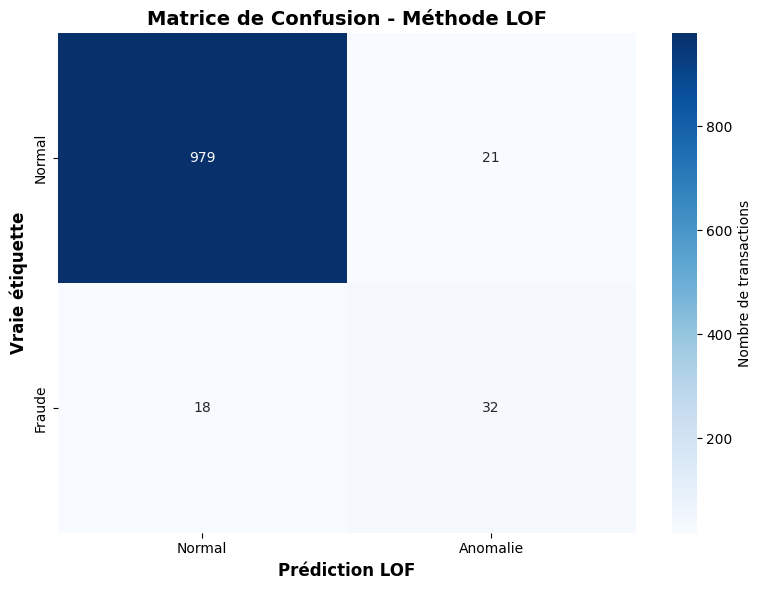


Détails de la matrice de confusion :
  Vrais Négatifs (VN)  :  979 - Transactions normales correctement identifiées
  Faux Positifs (FP)   :   21 - Transactions normales classées comme fraudes
  Faux Négatifs (FN)   :   18 - Fraudes manquées (non détectées)
  Vrais Positifs (VP)  :   32 - Fraudes correctement détectées

2. METRIQUES DE PERFORMANCE :
----------------------------------------------------------------------
Précision (Precision) : 0.6038 (60.38%)
  → Sur 53 transactions classées comme fraudes, 32 sont réellement des fraudes
  → Formule : VP / (VP + FP) = 32 / 53 = 0.6038

Rappel (Recall)       : 0.6400 (64.00%)
  → Sur 50 fraudes réelles, 32 ont été détectées
  → Formule : VP / (VP + FN) = 32 / 50 = 0.6400

F1-Score              : 0.6214
  → Moyenne harmonique de la précision et du rappel
  → Formule : 2 × (Précision × Rappel) / (Précision + Rappel) = 0.6214

Taux de détection     : 0.6400 (64.00%)
Taux de fausses alertes: 0.0210 (2.10%)


In [45]:
# TO DO

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

print("=" * 70)
print("QUESTION 6.5 : EVALUATION DE LA PERFORMANCE - METHODE LOF")
print("=" * 70)

y_true = df['fraude'].values 
y_pred = anomalies_lof.astype(int)  

cm = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred)
rappel = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n1. MATRICE DE CONFUSION :")
print("-" * 70)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomalie'],
            yticklabels=['Normal', 'Fraude'],
            cbar_kws={'label': 'Nombre de transactions'})
plt.xlabel('Prédiction LOF', fontsize=12, fontweight='bold')
plt.ylabel('Vraie étiquette', fontsize=12, fontweight='bold')
plt.title('Matrice de Confusion - Méthode LOF', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()

print(f"\nDétails de la matrice de confusion :")
print(f"  Vrais Négatifs (VN)  : {tn:4d} - Transactions normales correctement identifiées")
print(f"  Faux Positifs (FP)   : {fp:4d} - Transactions normales classées comme fraudes")
print(f"  Faux Négatifs (FN)   : {fn:4d} - Fraudes manquées (non détectées)")
print(f"  Vrais Positifs (VP)  : {tp:4d} - Fraudes correctement détectées")

print("\n" + "=" * 70)
print("2. METRIQUES DE PERFORMANCE :")
print("-" * 70)
print(f"Précision (Precision) : {precision:.4f} ({precision*100:.2f}%)")
print(f"  → Sur {tp + fp} transactions classées comme fraudes, {tp} sont réellement des fraudes")
print(f"  → Formule : VP / (VP + FP) = {tp} / {tp + fp} = {precision:.4f}")

print(f"\nRappel (Recall)       : {rappel:.4f} ({rappel*100:.2f}%)")
print(f"  → Sur {tp + fn} fraudes réelles, {tp} ont été détectées")
print(f"  → Formule : VP / (VP + FN) = {tp} / {tp + fn} = {rappel:.4f}")

print(f"\nF1-Score              : {f1:.4f}")
print(f"  → Moyenne harmonique de la précision et du rappel")
print(f"  → Formule : 2 × (Précision × Rappel) / (Précision + Rappel) = {f1:.4f}")

taux_detection = tp / (tp + fn) if (tp + fn) > 0 else 0
taux_fausses_alertes = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\nTaux de détection     : {taux_detection:.4f} ({taux_detection*100:.2f}%)")
print(f"Taux de fausses alertes: {taux_fausses_alertes:.4f} ({taux_fausses_alertes*100:.2f}%)")


Commentaire:
La méthode LOF obtient un F1-score de 0.62, avec une précision de 60.4% et un rappel de 64.0%. Elle détecte 32 fraudes sur 50 (taux de détection: 64.0%) avec seulement 21 fausses alertes sur 1000 transactions normales (taux de fausses alertes: 2.1%).
Cette performance est satisfaisante : LOF identifie la majorité des fraudes grâce à l'analyse de la densité locale, tout en maintenant un faible taux de fausses alertes. Les 18 fraudes non détectées ont probablement une densité locale similaire aux transactions normales, ce qui les rend plus difficiles à identifier par cette méthode.

### Question 6.6 (2 points)

Affichez les 10 premiers outliers pour chaque méthode abordée. Est-ce qu'il s'agit des mêmes données ? Sinon, selon vous, quelle est la cause de cette divergence ?

In [46]:
import numpy as np
import pandas as pd

print("=" * 70)
print("QUESTION 6.6 : COMPARAISON DES OUTLIERS ENTRE LES MÉTHODES")
print("=" * 70)

z_scores_montant = np.abs((df['montant_total'] - df['montant_total'].mean()) / df['montant_total'].std())
top10_zscore_montant = np.argsort(z_scores_montant)[-10:][::-1]

z_scores_quantite = np.abs((df['quantité'] - df['quantité'].mean()) / df['quantité'].std())
top10_zscore_quantite = np.argsort(z_scores_quantite)[-10:][::-1]

X_clustered = preprocessed_df.values
labels_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

distances_to_centroid = np.zeros(len(X_clustered))
for i in range(len(X_clustered)):
    cluster_id = labels_kmeans[i]
    distances_to_centroid[i] = np.linalg.norm(X_clustered[i] - centroids[cluster_id])

top10_clustering = np.argsort(distances_to_centroid)[-10:][::-1]

if 'reconstruction_errors_all' in globals():
    print("\nUtilisation des erreurs de reconstruction déjà calculées.")
    top10_autoencoder = np.argsort(reconstruction_errors_all)[-10:][::-1]
else:

    X_all = preprocessed_df.values
    
    print(f"\nType de données dans preprocessed_df : {preprocessed_df.dtypes.unique()}")
    print(f"Shape de X_all : {X_all.shape}")
    
    if X_all.dtype == 'object':
        preprocessed_df_numeric = preprocessed_df.apply(pd.to_numeric, errors='coerce')
        X_all = preprocessed_df_numeric.values.astype(np.float32)
    else:
        X_all = X_all.astype(np.float32)
    
    print(f"Shape finale pour l'autoencodeur : {X_all.shape}")
    
    X_reconstructed = autoencoder.model.predict(X_all, verbose=0)
    reconstruction_errors_all = np.mean(np.square(X_all - X_reconstructed), axis=1)
    
    top10_autoencoder = np.argsort(reconstruction_errors_all)[-10:][::-1]

top10_lof = np.argsort(lof_scores)[-10:][::-1]


print("\nTOP 10 OUTLIERS PAR MÉTHODE :")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Rang': range(1, 11),
    'Z-score (montant)': top10_zscore_montant,
    'Z-score (quantité)': top10_zscore_quantite,
    'Clustering': top10_clustering,
    'Autoencodeur': top10_autoencoder,
    'LOF': top10_lof
})

print(comparison_df.to_string(index=False))

print("\n" + "=" * 70)

QUESTION 6.6 : COMPARAISON DES OUTLIERS ENTRE LES MÉTHODES

Type de données dans preprocessed_df : [dtype('float64') dtype('bool')]
Shape de X_all : (1050, 14)
Shape finale pour l'autoencodeur : (1050, 14)

TOP 10 OUTLIERS PAR MÉTHODE :
 Rang  Z-score (montant)  Z-score (quantité)  Clustering  Autoencodeur  LOF
    1               1006                1042        1049          1006 1000
    2               1042                1006        1025          1042 1048
    3               1010                1026        1032          1026 1042
    4               1026                1049        1036          1048 1006
    5               1037                1010        1048          1000 1026
    6               1039                1025        1023          1010 1038
    7               1025                1036        1000          1037 1004
    8               1044                1015        1015          1039 1010
    9               1005                1011        1020          1049 1037
   

QUESTION : Est-ce qu'il s'agit des mêmes données ?

RÉPONSE : NON, il ne s'agit PAS principalement des mêmes données.

En observant le tableau :
- Très peu d'indices apparaissent dans toutes les colonnes
- Chaque méthode détecte en grande partie des outliers différents
- Exemples :
  - 1006 est détecté par Z-montant, Autoencodeur et LOF
  - 1000 est détecté uniquement par Clustering et LOF
  - 1049 apparaît dans Clustering, Z-quantité et Autoencodeur

CAUSE DE LA DIVERGENCE :

Les méthodes utilisent des approches fondamentalement différentes :

1. Z-SCORE : Détecte les valeurs extrêmes sur UNE variable
   → Ex: montant très élevé (5000€) ou quantité très élevée (50 unités)

2. CLUSTERING : Détecte les points éloignés de tous les groupes
   → Ex: transaction qui ne ressemble à aucun pattern typique

3. AUTOENCODEUR : Détecte les combinaisons de features inhabituelles
   → Ex: âge + catégorie + montant + ville = pattern jamais vu ensemble

4. LOF : Détecte les points isolés dans leur voisinage local
   → Ex: transaction normale globalement mais rare dans son contexte

Cette complémentarité est UTILE : combiner plusieurs méthodes permet de 
détecter plus de types de fraudes différents.